# Particle Classification CNN: 4-Class Hybrid Model

This notebook trains a CNN to classify cloud particles into 4 phases using:
- Particle images (128x128 grayscale)
- Environmental features: temperature, air speed, altitude

**Output:** 4-class classification
- Phase 0: Liquid
- Phase 1: Solid (Ice)
- Phase 2: Donut
- Phase 3: Noise

## 1. Import Libraries

In [1]:
import numpy as np
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Concatenate, BatchNormalization
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

## 2. Load and Prepare Data

**NOTE:** You need to have a DataFrame with the following columns:
- `particle_idx_seq`: matches the particle_X.png filenames
- `phase`: 0 for liquid, 1 for solid, 2 for donut, 3 for noise
- `ATX`: temperature value
- `TASX`: air speed value
- `GGALT`: altitude value

In [2]:
#connect to google drive
from google.colab import drive
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

drive.mount('/content/drive')

Found GPU at: /device:GPU:0
Mounted at /content/drive


In [3]:
base_path = '/content/drive/MyDrive/GEOG5100/aircraft_ml/'

# Load labeled data
df = pd.read_csv(base_path+'particle_df.csv')
if df is None:
    raise ValueError("Please load your labeled dataframe before proceeding")

# Display basic info about the dataset
print(f"Total labeled particles: {len(df)}")
print(f"\nClass distribution:")
print(df['phase'].value_counts().sort_index())
print(f"\nDataFrame info:")
df.head()

Total labeled particles: 7182

Class distribution:
phase
0    2392
1    1976
2    2168
3     646
Name: count, dtype: int64

DataFrame info:


,particle_idx_seq,Time,phase,xsize,ysize,area,diam
0,0,2025-05-24 02:28:03,0,40.0,120.0,20,124.01754
1,1,2025-05-24 02:32:55,0,20.0,70.0,9,70.82763
2,2,2025-05-24 02:38:27,0,20.0,70.0,10,70.82763
3,4641,2025-05-24 02:40:01,2,70.0,60.0,12,82.11102
4,4643,2025-05-24 02:40:57,0,160.0,130.0,123,162.14363


## 3. Load Particle Images

In [4]:
def load_particle_image(particle_num, image_dir=base_path, target_size=(128, 128)):
    """
    Load a single particle image and preprocess it.

    Parameters:
    -----------
    particle_num : int
        Particle number (corresponds to particle_X.png)
    image_dir : str
        Directory containing particle images
    target_size : tuple
        Target image size (height, width)

    Returns:
    --------
    image : np.ndarray
        Normalized image array of shape (target_size[0], target_size[1], 1)
    """
    # Check all possible directories in order
    subdirs = ['liquid', 'solid']

    for subdir in subdirs:
        img_path = os.path.join(image_dir, f'particle_images_filtered/{subdir}', f'particle_{particle_num}.png')
        if os.path.exists(img_path):
            # Load image as grayscale
            img = Image.open(img_path).convert('L')

            # Resize if necessary
            img = img.resize(target_size)

            # Convert to numpy array and normalize to [0, 1]
            img_array = np.array(img, dtype=np.float32) / 255.0

            # Add channel dimension
            img_array = np.expand_dims(img_array, axis=-1)

            return img_array

    #print(f"Warning: Image not found for particle {particle_num}")
    return None

In [5]:
# Load all images (with parallel processing for speed)
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm

print("Loading particle images in parallel...")

def load_image_wrapper(args):
    """Wrapper function for parallel image loading"""
    idx, particle_num = args
    img = load_particle_image(particle_num)
    return idx, img

# Prepare arguments for parallel processing
load_args = [(idx, row['particle_idx_seq'])
             for idx, row in df.iterrows()]

# Load images in parallel using ThreadPoolExecutor
images = []
valid_indices = []

with ThreadPoolExecutor(max_workers=8) as executor:
    # Use tqdm for progress bar
    results = list(tqdm(executor.map(load_image_wrapper, load_args),
                        total=len(load_args),
                        desc="Loading images"))

    for idx, img in results:
        if img is not None:
            images.append(img)
            valid_indices.append(idx)

# Convert to numpy array
X_images = np.array(images)

# Filter dataframe to only include particles with valid images
df_valid = df.loc[valid_indices].reset_index(drop=True)

print(f"\nSuccessfully loaded {len(X_images)} images")
print(f"Image shape: {X_images.shape}")

# Filter out phases 2 and 3 from both df_valid and X_images to ensure alignment
initial_num_images = len(X_images)
initial_num_df_rows = len(df_valid)

phase_filter_mask = df_valid['phase'].isin([0, 1])

df_valid = df_valid[phase_filter_mask].reset_index(drop=True)
X_images = X_images[phase_filter_mask]

print(f"Filtered for phases 0 and 1. Dropped {initial_num_df_rows - len(df_valid)} rows.")
print(f"New X_images shape: {X_images.shape}")
print(f"New df_valid shape: {df_valid.shape}")

Loading particle images in parallel...


Loading images: 100%|██████████| 7182/7182 [05:10<00:00, 23.15it/s]


Successfully loaded 4370 images
Image shape: (4370, 128, 128, 1)
Filtered for phases 0 and 1. Dropped 32 rows.
New X_images shape: (4338, 128, 128, 1)
New df_valid shape: (4338, 7)


## 4. Prepare Environmental Features

In [6]:
# Extract environmental features
print("Extracting feature names")
feature_columns = ['area','xsize']
X_features = df_valid[feature_columns].values

# Standardize the features (important for neural networks)
scaler = StandardScaler()
X_features_scaled = scaler.fit_transform(X_features)

# Handle NaN values in scaled features, replacing them with 0.0 (the mean of scaled features)
X_features_scaled = np.nan_to_num(X_features_scaled, nan=0.0)

print(f"Environmental features shape: {X_features_scaled.shape}")
print(f"\nFeature statistics (after scaling and NaN handling):")
print(pd.DataFrame(X_features_scaled, columns=feature_columns).describe())

Extracting feature names
Environmental features shape: (4338, 2)

Feature statistics (after scaling and NaN handling):
               area         xsize
count  4.338000e+03  4.338000e+03
mean  -2.620720e-17 -5.241440e-17
std    1.000115e+00  1.000115e+00
min   -9.938778e+00 -8.144952e-01
25%   -4.076043e-01 -6.764131e-01
50%   -3.872019e-01 -5.038104e-01
75%    3.008635e-02  3.937235e-01
max    8.135383e+00  3.569613e+00


In [7]:
print("Preparing data file paths and features...")

# Add the full image path to the DataFrame
def get_full_image_path(row, image_dir=base_path):
    """Determine the full path for a particle image."""
    particle_num = row['particle_idx_seq']
    subdirs = ['liquid', 'solid']

    for subdir in subdirs:
        img_path = os.path.join(image_dir, f'particle_images_filtered/{subdir}', f'particle_{particle_num}.png')
        if os.path.exists(img_path):
            return img_path
    return None

# Find all paths and filter the DataFrame
df['image_path'] = df.apply(get_full_image_path, axis=1)
df_valid = df.dropna(subset=['image_path']).reset_index(drop=True)

print(f"Total valid samples with images found: {len(df_valid)}")

Preparing data file paths and features...
Total valid samples with images found: 4370


In [8]:
# --- Step 2: Filter for specific phases (0 and 1) and synchronize data ---

# Filter out phases 2 and 3
phase_filter_mask = df_valid['phase'].isin([0, 1])
df_valid = df_valid[phase_filter_mask].reset_index(drop=True)

print(f"Filtered for phases 0 and 1. Final samples: {len(df_valid)}")

# Extract the final synchronized arrays
image_paths = df_valid['image_path'].values
#Use x_features that we scaled
#X_features # = df_valid[feature_columns].values # Assuming feature_columns is a list of column names
y_labels = pd.get_dummies(df_valid['phase']).values # Convert phase (0, 1) to one-hot labels (categorical)

print(f"Synchronized Data Shapes:")
print(f"  Image Paths: {image_paths.shape}")
print(f"  Features: {X_features_scaled.shape}")
print(f"  Labels (Categorical): {y_labels.shape}")

Filtered for phases 0 and 1. Final samples: 4338
Synchronized Data Shapes:
  Image Paths: (4338,)
  Features: (4338, 2)
  Labels (Categorical): (4338, 2)


In [9]:
# --- Step 3: Data Splitting (Image Paths, Features, Labels) ---

print("\nSplitting data...")
# Initial split: 90% temp, 10% test
X_paths_temp, X_paths_test, \
X_features_temp, X_features_test, \
y_temp, y_test = train_test_split(
    image_paths, X_features_scaled, y_labels,
    test_size=0.15,
    stratify=y_labels,
    random_state=42
)

# Second split: 89% train, 11% validation (of temp)
X_paths_train, X_paths_val, \
X_features_train, X_features_val, \
y_train, y_val = train_test_split(
    X_paths_temp, X_features_temp, y_temp,
    test_size=0.16,
    stratify=y_temp,
    random_state=42
)

print(f"Training set: {len(X_paths_train)} samples")
print(f"Validation set: {len(X_paths_val)} samples")
print(f"Test set: {len(X_paths_test)} samples")
print("Data is ready for the tf.data.Dataset pipeline.")


Splitting data...
Training set: 3097 samples
Validation set: 590 samples
Test set: 651 samples
Data is ready for the tf.data.Dataset pipeline.


In [10]:
# Extract labels and convert to one-hot encoding
from sklearn.utils import class_weight

y = df_valid['phase'].values
y_categorical = to_categorical(y, num_classes=2)

print(f"Labels shape: {y_categorical.shape}")
print(f"Class distribution: {np.bincount(y)}")
print(f"Class 0 (Liquid): {np.sum(y == 0)} samples ({np.sum(y == 0) / len(y) * 100:.1f}%)")
print(f"Class 1 (Solid): {np.sum(y == 1)} samples ({np.sum(y == 1) / len(y) * 100:.1f}%)")
# print(f"Class 2 (Donut): {np.sum(y == 2)} samples ({np.sum(y == 2) / len(y) * 100:.1f}%)")
# print(f"Class 3 (Noise): {np.sum(y == 3)} samples ({np.sum(y == 3) / len(y) * 100:.1f}%)")

# Calculate class weights for imbalanced data
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y),
    y=y
)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

print(f"\nClass weights (to handle imbalance):")
for i, w in class_weight_dict.items():
    print(f"  Class {i}: {w:.2f}")

Labels shape: (4338, 2)
Class distribution: [2373 1965]
Class 0 (Liquid): 2373 samples (54.7%)
Class 1 (Solid): 1965 samples (45.3%)

Class weights (to handle imbalance):
  Class 0: 0.91
  Class 1: 1.10


## Data augmentation

In [12]:
import tensorflow as tf
from typing import Tuple

# Define the image size based on your model architecture
IMAGE_SIZE = (128, 128)
AUGMENTATION_PROB = 0.5
MAX_SHIFT = 0.1 # 10% shift

def random_geometric_augment(image: tf.Tensor) -> tf.Tensor:

    # Cast constants to float32 once for calculations
    H, W, C = IMAGE_SIZE[0], IMAGE_SIZE[1], 1

    # --- 1. Rotation (Using robust tf.image.rot90) ---
    # Apply a random rotation of 0, 90, 180, or 270 degrees.
    k = tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
    image = tf.image.rot90(image, k=k)

    # --- 2. Zooming and Shifting (Manual Implementation) ---

    # A. Calculate random shifts in pixels
    max_shift_pixels = tf.cast(H, tf.float32) * tf.cast(MAX_SHIFT, tf.float32)
    # The result is float32. Now, you should cast the result back to int32
    # if you want the maximum shift in whole pixels for subsequent calculations.
    max_shift_pixels = tf.cast(max_shift_pixels, tf.int32)
    shift_h = tf.random.uniform(shape=[], minval=-max_shift_pixels, maxval=max_shift_pixels, dtype=tf.int32)
    shift_w = tf.random.uniform(shape=[], minval=-max_shift_pixels, maxval=max_shift_pixels, dtype=tf.int32)

    # B. Apply Translation (Shift) using Padding and Cropping

    # Calculate padding needed to cover the max shift
    pad_h = tf.abs(shift_h)
    pad_w = tf.abs(shift_w)

    # Pad the image symmetrically by the maximum possible shift
    padded_image = tf.pad(
        image,
        [[pad_h, pad_h], [pad_w, pad_w], [0, 0]],
        mode='CONSTANT',
        constant_values=0.0 # Black background for binary images
    )

    # Calculate the starting point for cropping back to the original size
    # Start H = max_shift_pixels + shift_h (to correctly apply positive/negative shift)
    # The starting point is the padding size plus the calculated shift.
    start_h = pad_h + shift_h
    start_w = pad_w + shift_w

    # Crop the padded image back to the original size (128, 128)
    image = tf.image.crop_to_bounding_box(
        padded_image,
        offset_height=start_h,
        offset_width=start_w,
        target_height=H,
        target_width=W
    )

    # C. Apply Random Zoom
    zoom_factor = tf.random.uniform(shape=[], minval=0.9, maxval=1.1, dtype=tf.float32)

    if zoom_factor < 1.0:
        # Zoom out (pad with black background)
        pad_h = tf.cast(tf.cast(H, tf.float32) * (1.0 - zoom_factor) / 2.0, tf.int32)
        pad_w = tf.cast(tf.cast(W, tf.float32) * (1.0 - zoom_factor) / 2.0, tf.int32)
        image = tf.pad(image, [[pad_h, pad_h], [pad_w, pad_w], [0, 0]], constant_values=0.0)
        image = tf.image.resize(image, IMAGE_SIZE, method='nearest')
    elif zoom_factor > 1.0:
        # Zoom in (crop and resize)
        crop_h = tf.cast(tf.cast(H, tf.float32) / zoom_factor, tf.int32)
        crop_w = tf.cast(tf.cast(W, tf.float32) / zoom_factor, tf.int32)

        offset_h = (H - crop_h) // 2
        offset_w = (W - crop_w) // 2

        image = tf.image.crop_to_bounding_box(image, offset_h, offset_w, crop_h, crop_w)
        image = tf.image.resize(image, IMAGE_SIZE, method='nearest')

    return image

In [ ]:
import tensorflow as tf
from typing import Tuple

# Define the image size
IMAGE_SIZE = (128, 128)
AUGMENTATION_PROB = 0.5 # Probability for applying each augmentation step

def load_and_augment_hybrid(
    image_path: str, feature_vector: tf.Tensor, label: tf.Tensor, augment: bool
) -> Tuple[Tuple[tf.Tensor, tf.Tensor], tf.Tensor]:
    """
    Loads an image from path, preprocesses it, applies conditional augmentation,
    and returns the structured inputs and label for the hybrid model.
    """

    # 1. Image Loading and Initial Processing
    image = tf.io.read_file(filename=image_path)
    # Decode PNG (assuming your particle images are PNG) as grayscale (1 channel)
    image = tf.image.decode_png(contents=image, channels=1)

    # Convert to float32 and resize (Normalization will happen after augmentation)
    image = tf.image.convert_image_dtype(image=image, dtype=tf.float32)
    image = tf.image.resize(images=image, size=IMAGE_SIZE)

    # 2. Apply Augmentation (Only if 'augment' is True and based on probability)
    if augment:
        image = random_geometric_augment(image)

    # 3. Final Normalization/Clipping
    image = tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

    # 4. Return in the format Keras model.fit expects: ( [image_input, feature_input], label )
    return (image, feature_vector), label

In [15]:
# --- Configuration ---
BATCH_SIZE = 32

print("Building tf.data.Dataset pipelines...")

# --- 1. Training Dataset (with augmentation) ---
train_ds = tf.data.Dataset.from_tensor_slices(
    (X_paths_train, X_features_train, y_train)
)

# Apply the loading and augmentation function
train_ds = train_ds.map(
    lambda p, f, l: load_and_augment_hybrid(p, f, l, augment=True),
    num_parallel_calls=tf.data.AUTOTUNE # Parallelize data loading for speed
)

# Cache data for speed, shuffle, batch, and prefetch
train_ds = train_ds.cache()
train_ds = train_ds.shuffle(buffer_size=len(X_paths_train))
train_ds = train_ds.batch(BATCH_SIZE)
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE) # Pre-load next batch

print("Training Dataset prepared.")

# --- 2. Validation Dataset (no augmentation) ---
val_ds = tf.data.Dataset.from_tensor_slices(
    (X_paths_val, X_features_val, y_val)
)

# Apply the loading and processing function (augment=False)
val_ds = val_ds.map(
    lambda p, f, l: load_and_augment_hybrid(p, f, l, augment=False),
    num_parallel_calls=tf.data.AUTOTUNE
)

# Cache data, batch, and prefetch (no shuffle needed for validation)
val_ds = val_ds.cache()
val_ds = val_ds.batch(BATCH_SIZE)
val_ds = val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

print("Validation Dataset prepared.")

# --- 3. Test Dataset (for final evaluation) ---
test_ds = tf.data.Dataset.from_tensor_slices(
    (X_paths_test, X_features_test, y_test)
)

# Apply the loading and processing function (augment=False)
test_ds = test_ds.map(
    lambda p, f, l: load_and_augment_hybrid(p, f, l, augment=False),
    num_parallel_calls=tf.data.AUTOTUNE
)

# Batch and prefetch
test_ds = test_ds.batch(BATCH_SIZE)
test_ds = test_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

print("All datasets successfully created. Ready for model compilation and training.")

Building tf.data.Dataset pipelines...
Training Dataset prepared.
Validation Dataset prepared.
All datasets successfully created. Ready for model compilation and training.


## 5. Visualize Sample Particles

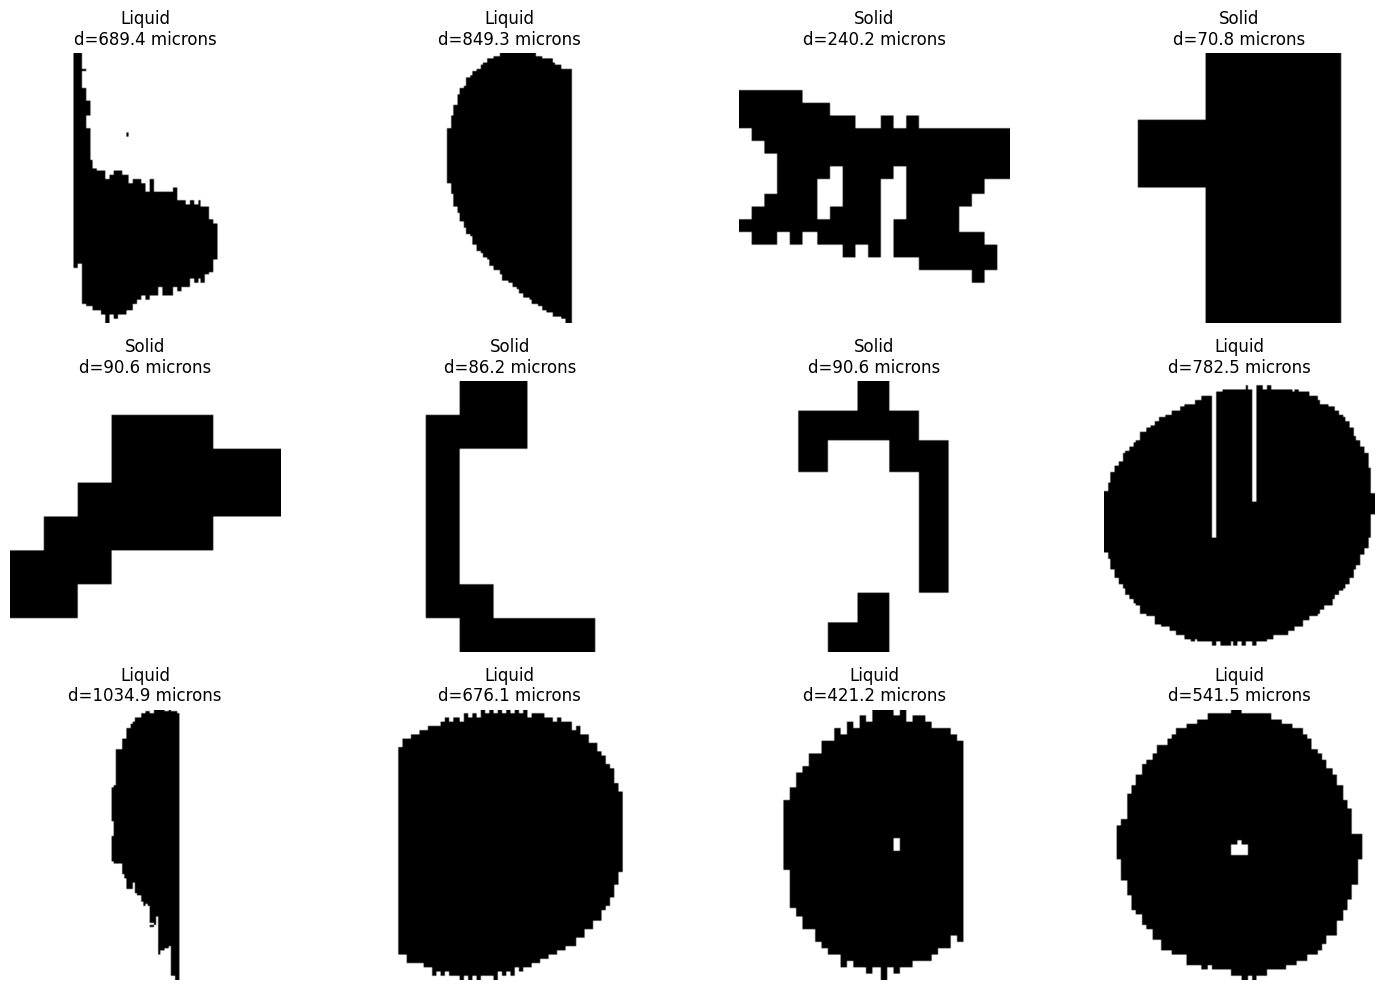

In [16]:
def get_class_name(label):
    """Convert numeric label to class name"""
    class_names = {0: 'Liquid', 1: 'Solid'}
    return class_names.get(label, 'Unknown')

# Display random samples
plt.figure(figsize=(15, 10))
for i in range(12):
    plt.subplot(3, 4, i+1)
    idx = np.random.randint(0, len(X_images))
    plt.imshow(X_images[idx, :, :, 0], cmap='gray')
    plt.title(f'{get_class_name(y[idx])}\nd={df_valid.iloc[idx]["diam"]:.1f} microns')
    plt.axis('off')
plt.tight_layout()
plt.show()

\## 7. Build the Hybrid CNN Model

This model uses a multi-input architecture:
- **CNN branch**: Processes particle images to extract morphological features
- **Dense branch**: Processes environmental features (temperature, air speed, altitude)
- **Concatenation**: Combines both branches before final classification

This hybrid approach leverages both visual particle characteristics and atmospheric conditions for improved classification.

In [17]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout, Concatenate,SpatialDropout2D
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers

# L2 regularization strength (a common starting value)
L2_REG = 0.0001

image_input = Input(shape=(128, 128, 1), name='image_input')

# Reduce initial filters for simpler images
x = Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same',
           kernel_regularizer=regularizers.l2(L2_REG))(image_input)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = SpatialDropout2D(0.2)(x)  # Spatial dropout for conv layers

x = Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same',
           kernel_regularizer=regularizers.l2(L2_REG))(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = SpatialDropout2D(0.2)(x)

x = Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same',
           kernel_regularizer=regularizers.l2(L2_REG))(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = SpatialDropout2D(0.3)(x)

# Flatten the CNN output
x = Flatten()(x)
# Increase Dropout rate
x = Dropout(0.5)(x)
# Simplify and add L2 regularization
cnn_output = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(L2_REG))(x)


# Environmental features input branch
feature_input = Input(shape=(len(feature_columns),), name='feature_input')

# Process environmental features (Add L2)
f = Dense(32, activation='relu', kernel_regularizer=regularizers.l2(L2_REG))(feature_input)
# Increase Dropout rate
f = Dropout(0.3)(f)
# Simplify and add L2
feature_output = Dense(16, activation='relu', kernel_regularizer=regularizers.l2(L2_REG))(f)


# Concatenate both branches
combined = Concatenate()([cnn_output, feature_output])

# Final classification layers
# Simpler final layers
z = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(L2_REG))(combined)
z = Dropout(0.5)(z)
z = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(L2_REG))(z)
z = Dropout(0.3)(z)

# Output layer (2-class classification: liquid, solid)
# Assuming you switched to binary crossentropy loss:
#output = Dense(1, activation='sigmoid', name='output')(z)
# OR, if using categorical crossentropy for 2 classes (one-hot):
output = Dense(2, activation='softmax', name='output')(z)


# Create the model
model = Model(inputs=[image_input, feature_input], outputs=output, name='Hybrid_CNN_Regularized_V2')
# Display model architecture
model.summary()

Model: "Hybrid_CNN_Regularized_V2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        160 │ image_input[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │         64 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout2d   │ (None, 64, 64,    │          0 │ max_pooling2d[0]… │
│ (SpatialDropout2D)  │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 64,    │      4,640 │ spatial_dropout2… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout2d_1 │ (None, 32, 32,    │          0 │ max_pooling2d_1[… │
│ (SpatialDropout2D)  │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │     18,496 │ spatial_dropout2… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout2d_2 │ (None, 16, 16,    │          0 │ max_pooling2d_2[… │
│ (SpatialDropout2D)  │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ feature_input       │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 16384)     │          0 │ spatial_dropout2… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │         96 │ feature_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 16384)     │          0 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 32)        │          0 │ dense_1[0][0]   

 Total params: 1,091,762 (4.16 MB)

 Trainable params: 1,091,538 (4.16 MB)

 Non-trainable params: 224 (896.00 B)

## 8. Compile the Model

In [18]:
from tensorflow.keras.callbacks import ReduceLROnPlateau# Exponential learning rate decay


lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,              # Reduce LR by half
    patience=3,              # Wait 3 epochs before reducing
    min_lr=1e-7,
    verbose=1
)

In [19]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall, AUC
def compile_model(model):
    """
    Compile the model with appropriate loss function and optimizer.
    """
    model.compile(
        optimizer=Adam(learning_rate=0.0001),  # Start lower
        loss='categorical_crossentropy',
        metrics=['accuracy', Precision(), Recall(), AUC()]
    )

In [20]:
# Compile with appropriate loss function and optimizer

compile_model(model)

## 9. Set Up Callbacks

In [21]:

# --- 1. Early Stopping (Updated Patience) ---
early_stop = EarlyStopping(
    monitor='val_loss', # Monitors the metric you want to minimize
    mode='min',         # Stop when val_loss stops decreasing
    patience=10,        # Reduced patience to 10 epochs
    verbose=1,
    restore_best_weights=True
)

# --- 2. Model Checkpoint (Updated Monitoring and Naming) ---
checkpoint = ModelCheckpoint(
    # Updated file name for clarity (assuming binary classification)
    'best_particle_classifier_hybrid_binary.keras',
    monitor='val_loss', # Changed to monitor val_loss, matching EarlyStopping
    mode='min',         # Save when val_loss is at its minimum
    verbose=1,
    save_best_only=True
)

print("Callbacks configured for robust training.")

Callbacks configured for robust training.


## 10. Train the Model

In [22]:
# --- Calculate Steps Per Epoch ---
# When using tf.data.Dataset, you need to tell Keras how many batches
# make up one epoch.
N_TRAIN_SAMPLES = len(X_paths_train) # Use the count of training samples
N_VAL_SAMPLES = len(X_paths_val)     # Use the count of validation samples
N_EPOCHS = 40
steps_per_epoch = N_TRAIN_SAMPLES // BATCH_SIZE
# Use validation_steps to ensure validation is done over the entire set
validation_steps = N_VAL_SAMPLES // BATCH_SIZE
# If the number of samples is not perfectly divisible, you might add 1 to the steps
if N_TRAIN_SAMPLES % BATCH_SIZE != 0:
    steps_per_epoch += 1
if N_VAL_SAMPLES % BATCH_SIZE != 0:
    validation_steps += 1
# --- Train the model with class weights using the Datasets ---
print("Starting training with class weights...")
print(f"Using class weights:")
for i, w in class_weight_dict.items():
    print(f"  Class {i} ({get_class_name(i)}): {w:.2f}")

history = model.fit(
    # 1. Pass the training dataset object
    train_ds,
    # 2. Set the number of steps per epoch
    steps_per_epoch=steps_per_epoch,
    epochs=N_EPOCHS,
    # 3. Pass the validation dataset object
    validation_data=val_ds,
    # 4. Set the validation steps
    validation_steps=validation_steps,
    # 5. Keep class weights (applied per batch)
    class_weight=class_weight_dict,
    callbacks=[early_stop, checkpoint],
    verbose=1
)

print("\nTraining complete!")

Starting training with class weights...
Using class weights:
  Class 0 (Liquid): 0.91
  Class 1 (Solid): 1.10
Epoch 1/40
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.5512 - auc: 0.5642 - loss: 1.0889 - precision: 0.5512 - recall: 0.5512
Epoch 1: val_loss improved from inf to 0.67453, saving model to best_particle_classifier_hybrid_binary.keras
97/97 ━━━━━━━━━━━━━━━━━━━━ 32s 148ms/step - accuracy: 0.5514 - auc: 0.5646 - loss: 1.0874 - precision: 0.5514 - recall: 0.5514 - val_accuracy: 0.7746 - val_auc: 0.8188 - val_loss: 0.6745 - val_precision: 0.7746 - val_recall: 0.7746
Epoch 2/40
92/97 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6169 - auc: 0.6656 - loss: 0.7436 - precision: 0.6169 - recall: 0.6169
Epoch 2: val_loss improved from 0.67453 to 0.59650, saving model to best_particle_classifier_hybrid_binary.keras
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6174 - auc: 0.6665 - loss: 0.7426 - precision: 0.6174 - recall: 0.6174 - val_accuracy: 0.7424 - val_auc: 0.8349 

## 11. Visualize Training History

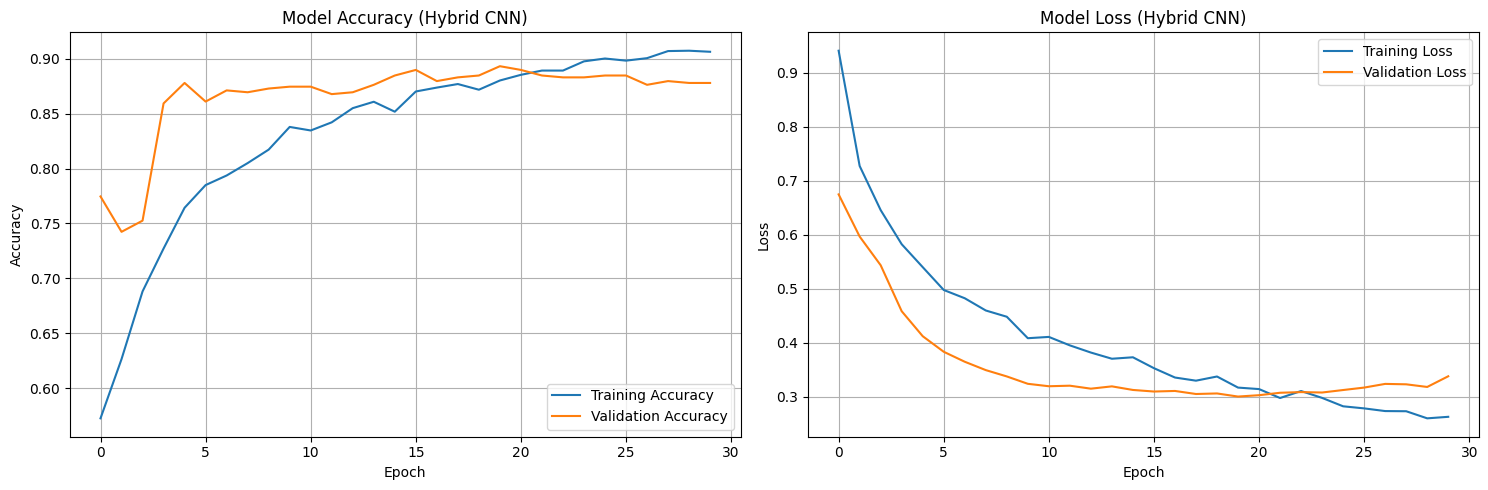


Final Training Accuracy: 0.9064
Final Validation Accuracy: 0.8780
Best Validation Accuracy: 0.8932


In [23]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot accuracy
axes[0].plot(history.history['accuracy'], label='Training Accuracy')
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[0].set_title('Model Accuracy (Hybrid CNN)')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].legend()
axes[0].grid(True)

# Plot loss
axes[1].plot(history.history['loss'], label='Training Loss')
axes[1].plot(history.history['val_loss'], label='Validation Loss')
axes[1].set_title('Model Loss (Hybrid CNN)')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

# Print final metrics
print(f"\nFinal Training Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")
print(f"Best Validation Accuracy: {max(history.history['val_accuracy']):.4f}")

In [139]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Assuming your test data is processed and synchronized as NumPy arrays for simplicity
# If using the test_ds generator, you must iterate it to get all X and y_true values.
# For simplicity, we assume you have the test arrays: X_features_test, X_paths_test, y_test
# and load the full test data here (or use the test_ds object)

# 1. Get the true labels
# If y_test is one-hot (e.g., [[1, 0], [0, 1]]), extract the positive class column (index 1)
y_true = y_test[:, 1]

# 2. Get the model's probability predictions for the test set
# If using the tf.data.Dataset pipeline:
y_pred_probs = model.predict(test_ds)

# If your model output is Dense(1, sigmoid), y_pred_probs is already (N_samples, 1)
# If your model output is Dense(2, softmax), y_pred_probs has shape (N_samples, 2).
# We take the probability of the positive class (index 1).
if y_pred_probs.shape[1] > 1:
    y_scores = y_pred_probs[:, 1]
else:
    y_scores = y_pred_probs

41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step


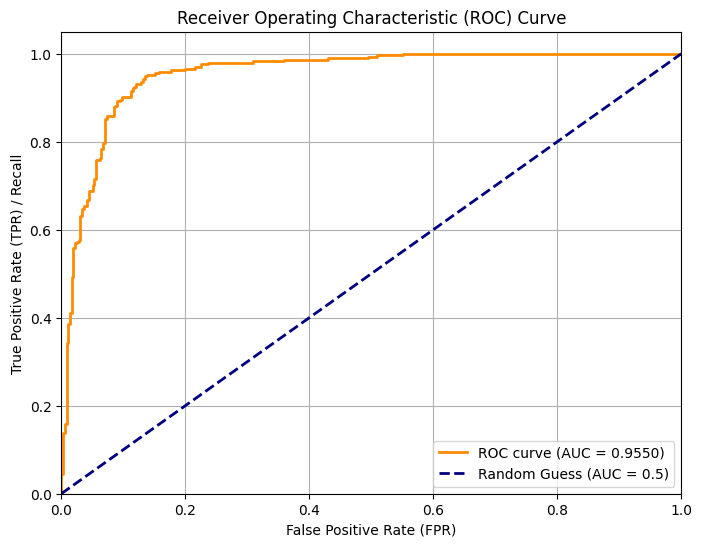

In [140]:
# Calculate the True Positive Rate (TPR) and False Positive Rate (FPR)
fpr, tpr, thresholds = roc_curve(y_true, y_scores)

# Calculate the AUC
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess (AUC = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR) / Recall')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

## 12. Evaluate on Test Set

In [141]:
# Load the best model
from keras.models import load_model

best_model = load_model('best_particle_classifier_hybrid_binary.keras')

# Evaluate on training set
train_metrics = best_model.evaluate(train_ds, verbose=0)
# Evaluate on validation set
val_metrics = best_model.evaluate(val_ds, verbose=0)
# Evaluate on test set
test_metrics = best_model.evaluate(test_ds, verbose=0)

# The metrics list order is: [Loss, Accuracy, Precision, Recall, AUC]
# Note: Ensure your model was compiled with these metrics for this to work
metric_names = ['Loss', 'Accuracy', 'Precision', 'Recall', 'AUC']

# --- 3. Print Results ---
print("\n" + "=" * 50)
print("HYBRID BINARY CNN PERFORMANCE")
print("=" * 50)

def print_metrics(set_name, metrics):
    """Helper function to print formatted metrics."""
    print(f"\n--- {set_name} Set ---")
    for name, value in zip(metric_names, metrics):
        if name == 'Accuracy':
            print(f'{name}: {value:.4f} ({value*100:.2f}%)')
        else:
            print(f'{name}: {value:.4f}')

print_metrics("Training", train_metrics)
print_metrics("Validation", val_metrics)
print_metrics("Test", test_metrics)

print("\n" + "=" * 50)


HYBRID BINARY CNN PERFORMANCE

--- Training Set ---
Loss: 0.2634
Accuracy: 0.9144 (91.44%)
Precision: 0.9144
Recall: 0.9144
AUC: 0.9717

--- Validation Set ---
Loss: 0.3017
Accuracy: 0.9000 (90.00%)
Precision: 0.9000
Recall: 0.9000
AUC: 0.9596

--- Test Set ---
Loss: 0.3130
Accuracy: 0.8986 (89.86%)
Precision: 0.8986
Recall: 0.8986
AUC: 0.9559



Extracted 651 test images

COMPREHENSIVE MISCLASSIFICATION ANALYSIS

MISCLASSIFICATION ANALYSIS
Total test samples: 651
Misclassified: 62 (9.52%)

Liquid → Solid errors: 32 (9.0% of liquids)
Solid → Liquid errors: 30 (10.2% of solids)



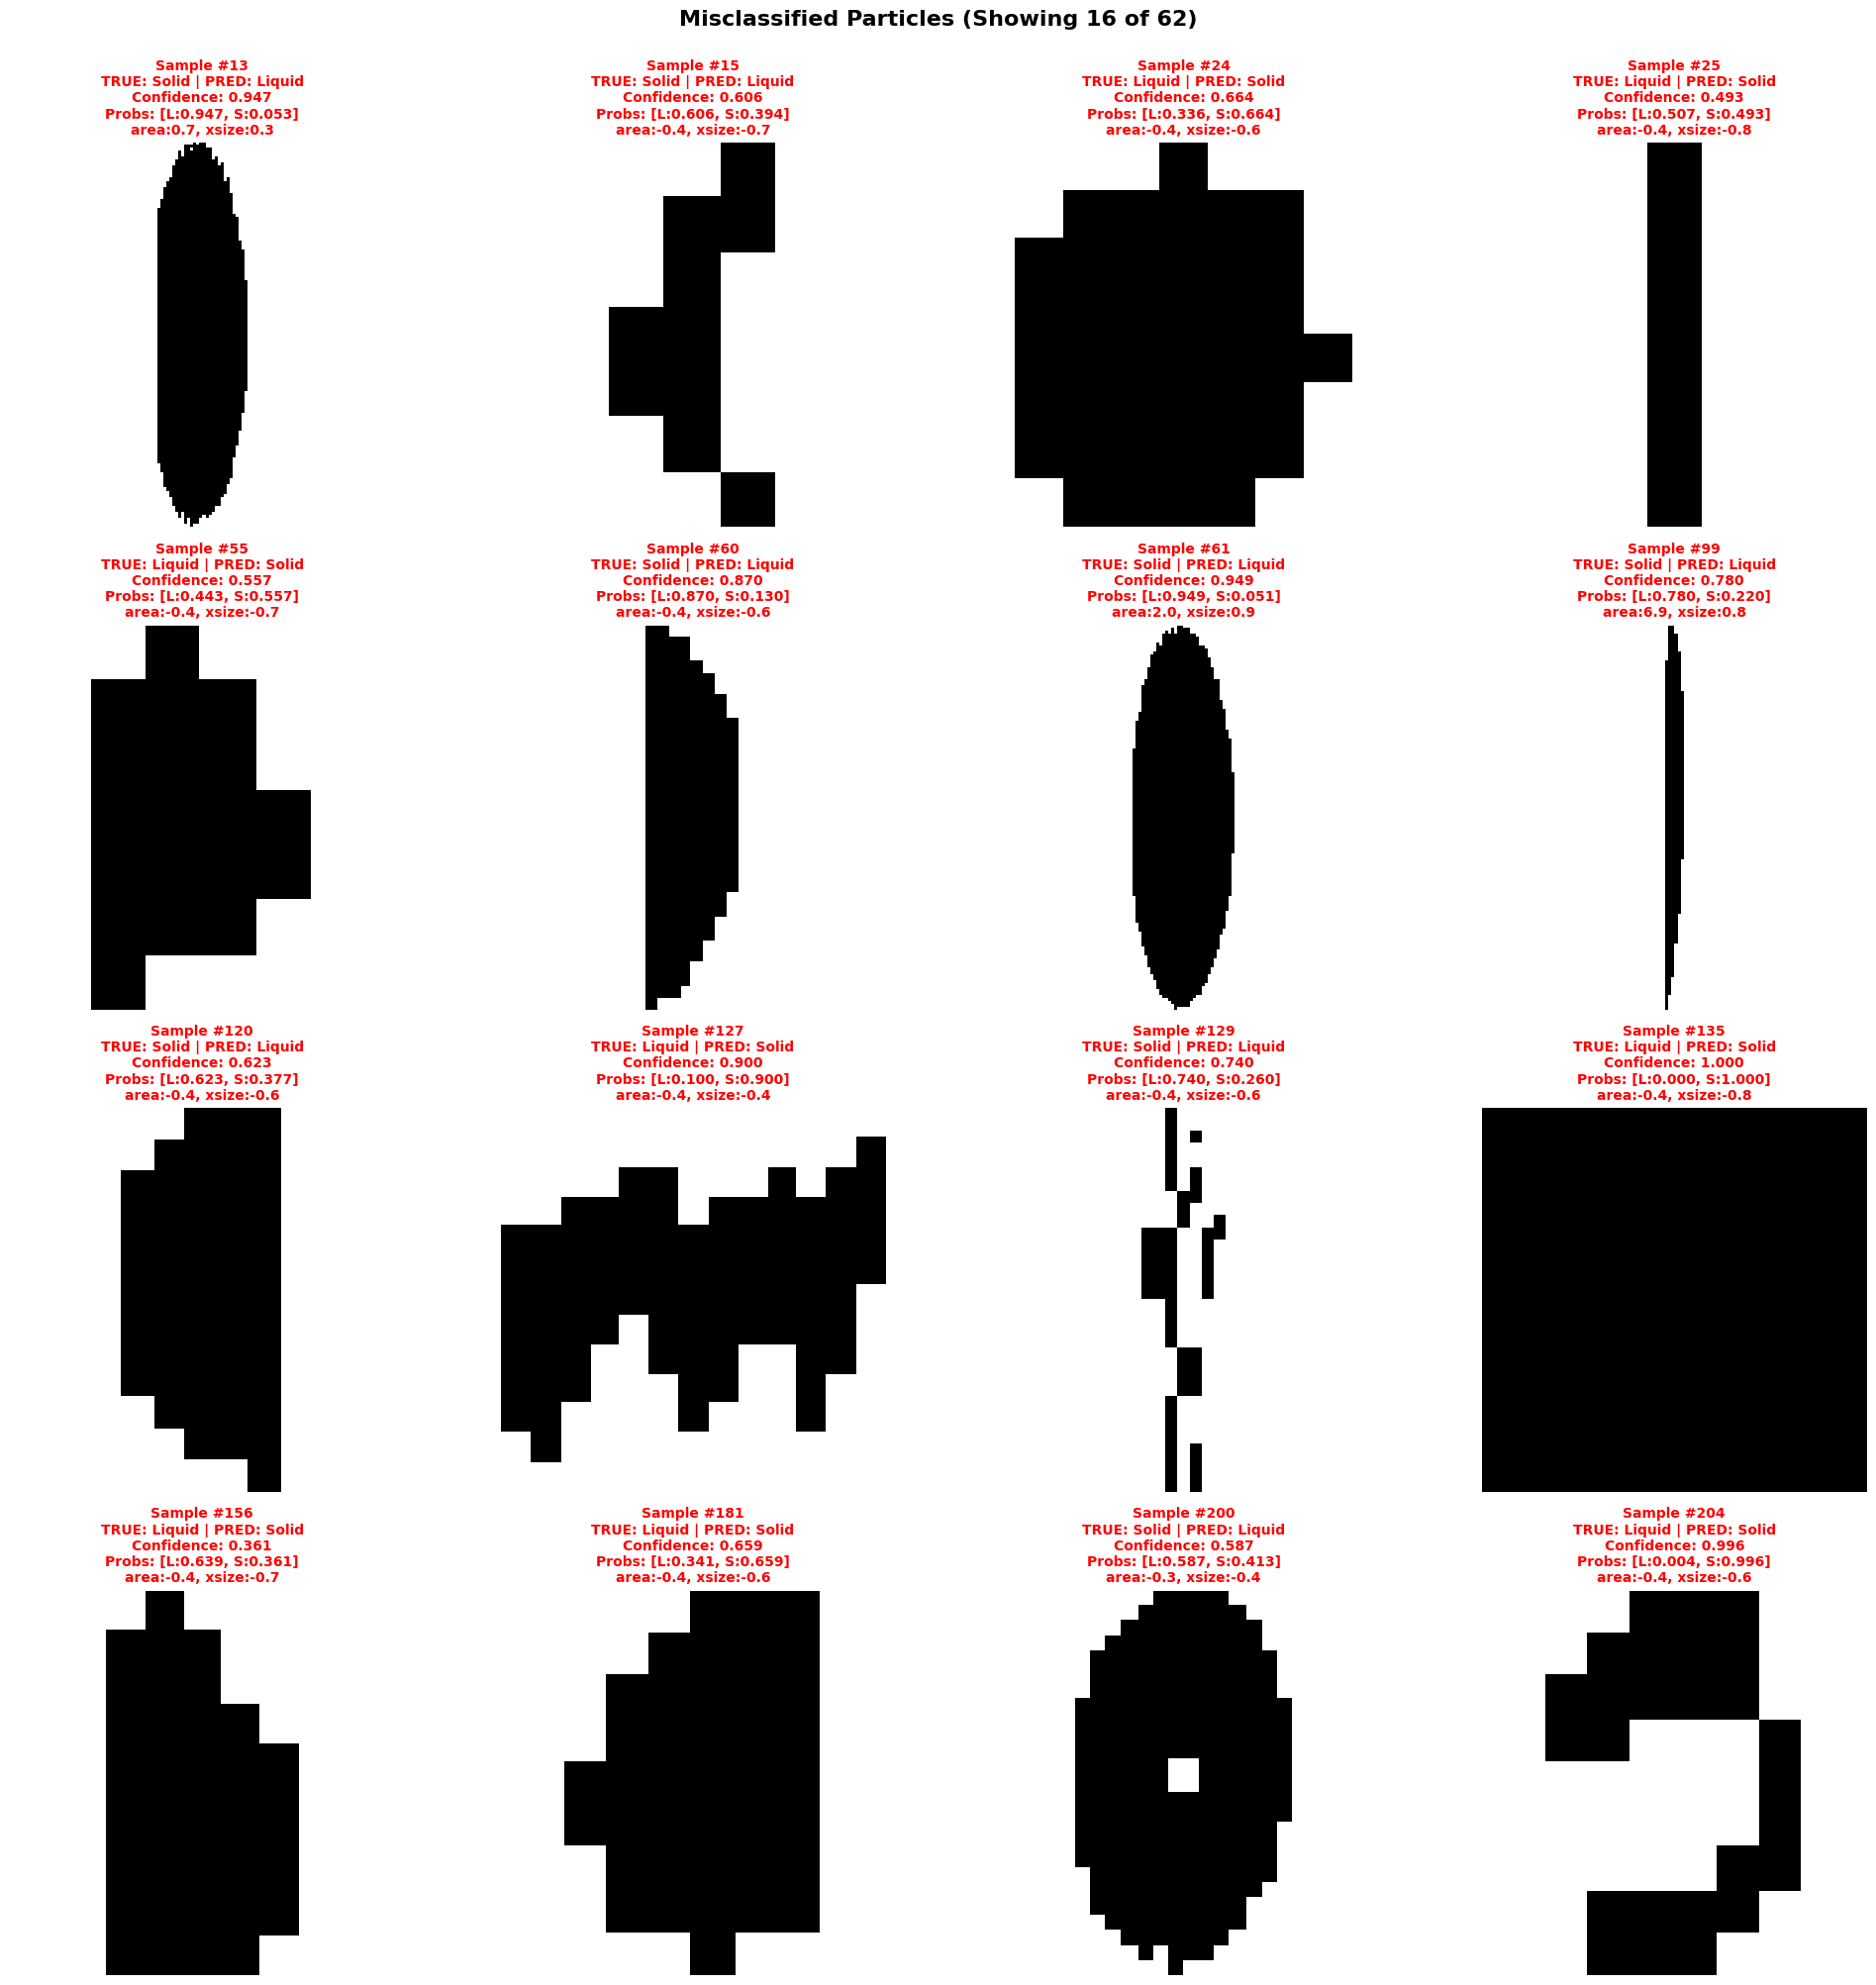


DETAILED MISCLASSIFICATION STATISTICS

Confidence Analysis:
  Misclassified - Mean confidence: 0.719 (±0.208)
  Correct       - Mean confidence: 0.920 (±0.143)

Feature Statistics for Misclassified Samples:
  area: mean=-0.18, std=1.00, range=[-0.41, 6.87]
  xsize: mean=-0.51, std=0.39, range=[-0.81, 0.95]




/tmp/ipython-input-2330592014.py:185: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax2.boxplot([liquid_correct, liquid_incorrect, solid_correct, solid_incorrect],


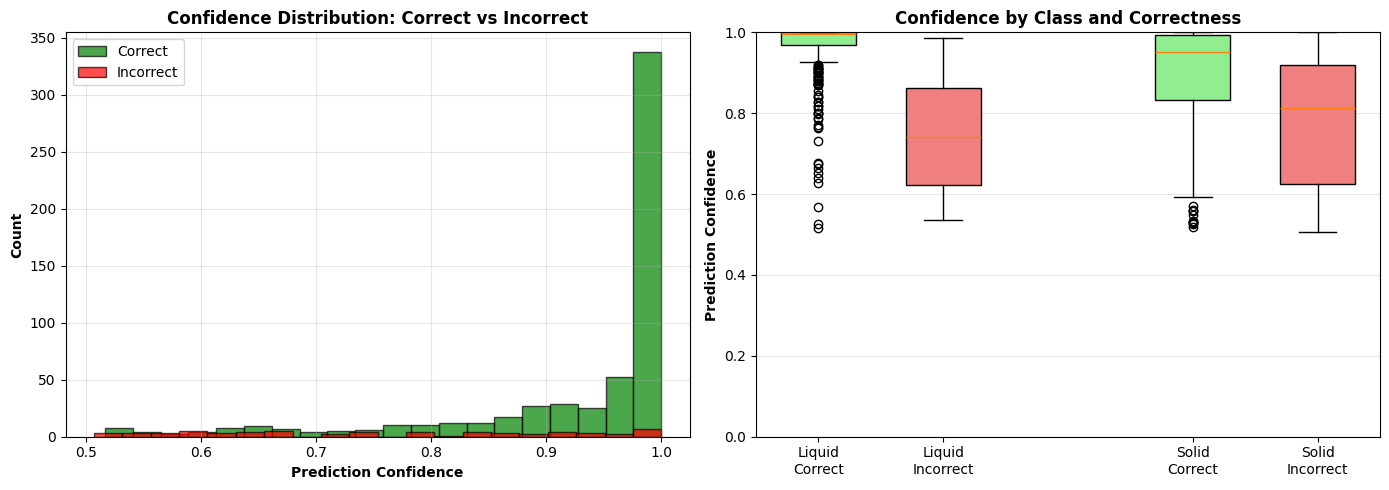

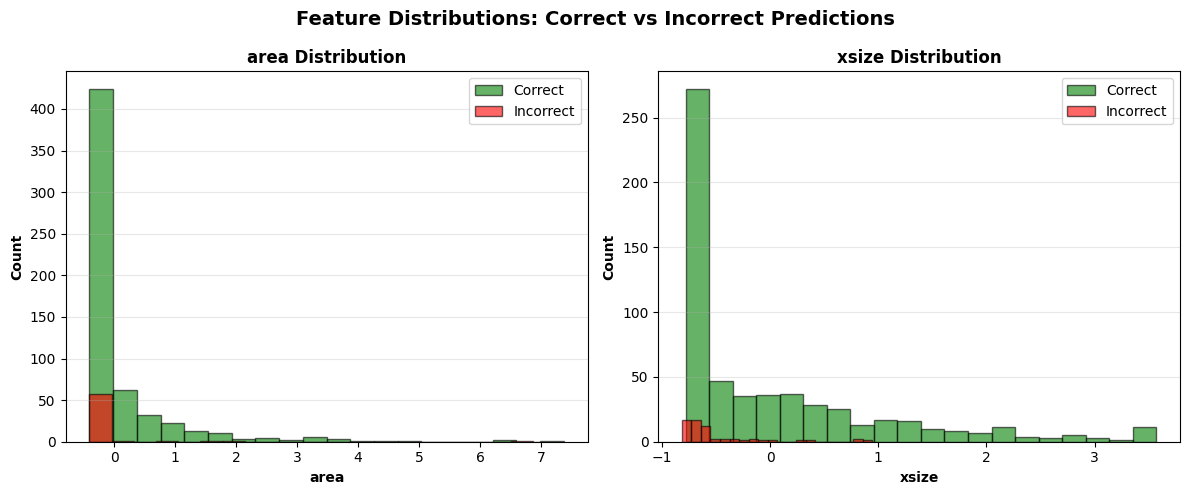



LOW CONFIDENCE PREDICTIONS (confidence < 0.7)
Total low confidence predictions: 70 (10.75%)
  Correct: 44 (62.9%)
  Incorrect: 26 (37.1%)

These are ambiguous cases where the model is uncertain.

Analysis complete! Check the saved images:
  - misclassified_particles.png
  - confidence_analysis.png
  - feature_distributions.png


In [121]:
import matplotlib.pyplot as plt
import numpy as np

def get_class_name(class_idx):
    """Convert class index to name."""
    return 'Liquid' if class_idx == 0 else 'Solid'


def get_all_images_from_dataset(test_ds):
    """Extract all images from batched test dataset."""
    all_images = []
    all_features = []
    all_labels = []

    for batch in test_ds:
        (images, features), labels = batch
        all_images.append(images.numpy())
        all_features.append(features.numpy())
        all_labels.append(labels.numpy())

    all_images = np.concatenate(all_images, axis=0)
    all_features = np.concatenate(all_features, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    return all_images, all_features, all_labels


# Extract images and labels from test dataset
test_images, test_features, test_labels = get_all_images_from_dataset(test_ds)
print(f"Extracted {len(test_images)} test images")

# Convert one-hot labels to class indices
y_true = np.argmax(test_labels, axis=1)


def plot_misclassified_particles(y_true, y_pred, y_pred_probs, test_images, test_features,
                                  feature_columns, max_display=16):
    """
    Plot all misclassified particles with detailed information.

    Parameters:
    - y_true: True labels (class indices)
    - y_pred: Predicted labels (class indices)
    - y_pred_probs: Prediction probabilities
    - test_images: Test images array
    - test_features: Test features array
    - feature_columns: List of feature names
    - max_display: Maximum number of samples to display
    """
    # Find misclassified indices
    misclassified_idx = np.where(y_pred != y_true)[0]

    print("=" * 80)
    print(f"MISCLASSIFICATION ANALYSIS")
    print("=" * 80)
    print(f"Total test samples: {len(y_true)}")
    print(f"Misclassified: {len(misclassified_idx)} ({len(misclassified_idx)/len(y_true)*100:.2f}%)")
    print()

    # Analyze misclassification patterns
    # Liquid misclassified as Solid
    liquid_as_solid = np.where((y_true == 0) & (y_pred == 1))[0]
    # Solid misclassified as Liquid
    solid_as_liquid = np.where((y_true == 1) & (y_pred == 0))[0]

    print(f"Liquid → Solid errors: {len(liquid_as_solid)} ({len(liquid_as_solid)/np.sum(y_true==0)*100:.1f}% of liquids)")
    print(f"Solid → Liquid errors: {len(solid_as_liquid)} ({len(solid_as_liquid)/np.sum(y_true==1)*100:.1f}% of solids)")
    print()

    if len(misclassified_idx) == 0:
        print("🎉 No misclassifications! Perfect model!")
        return

    # Limit display
    display_idx = misclassified_idx[:max_display]
    n_samples = len(display_idx)

    # Calculate grid size
    n_cols = 4
    n_rows = int(np.ceil(n_samples / n_cols))

    fig = plt.figure(figsize=(20, 5*n_rows))

    for plot_idx, sample_idx in enumerate(display_idx):
        ax = plt.subplot(n_rows, n_cols, plot_idx + 1)

        # Get data
        image = test_images[sample_idx, :, :, 0]
        true_class = y_true[sample_idx]
        pred_class = y_pred[sample_idx]
        confidence = y_pred_probs[sample_idx, pred_class]

        # Get feature values
        features = test_features[sample_idx]

        # Display image
        ax.imshow(image, cmap='gray')

        # Create detailed title
        title = f"Sample #{sample_idx}\n"
        title += f"TRUE: {get_class_name(true_class)} | PRED: {get_class_name(pred_class)}\n"
        title += f"Confidence: {confidence:.3f}\n"
        title += f"Probs: [L:{y_pred_probs[sample_idx, 0]:.3f}, S:{y_pred_probs[sample_idx, 1]:.3f}]\n"

        # Add feature information
        if len(feature_columns) == 1:
            title += f"{feature_columns[0]}: {features[0]:.1f}"
        else:
            feature_str = ", ".join([f"{name}:{val:.1f}" for name, val in zip(feature_columns, features)])
            title += f"{feature_str}"

        ax.set_title(title, fontsize=10, color='red', weight='bold')
        ax.axis('off')

    plt.suptitle(f'Misclassified Particles (Showing {n_samples} of {len(misclassified_idx)})',
                 fontsize=16, weight='bold', y=1.0)
    plt.tight_layout()
    plt.savefig('misclassified_particles.png', dpi=150, bbox_inches='tight')
    plt.show()

    # Print detailed statistics
    print("\n" + "=" * 80)
    print("DETAILED MISCLASSIFICATION STATISTICS")
    print("=" * 80)

    if len(misclassified_idx) > 0:
        # Confidence analysis
        misclass_confidences = y_pred_probs[misclassified_idx, y_pred[misclassified_idx]]
        correct_idx = np.where(y_pred == y_true)[0]
        correct_confidences = y_pred_probs[correct_idx, y_pred[correct_idx]]

        print(f"\nConfidence Analysis:")
        print(f"  Misclassified - Mean confidence: {np.mean(misclass_confidences):.3f} (±{np.std(misclass_confidences):.3f})")
        print(f"  Correct       - Mean confidence: {np.mean(correct_confidences):.3f} (±{np.std(correct_confidences):.3f})")

        # Feature analysis for misclassified samples
        print(f"\nFeature Statistics for Misclassified Samples:")
        misclass_features = test_features[misclassified_idx]

        for i, feat_name in enumerate(feature_columns):
            if len(feature_columns) == 1:
                feat_values = misclass_features
            else:
                feat_values = misclass_features[:, i]
            print(f"  {feat_name}: mean={np.mean(feat_values):.2f}, "
                  f"std={np.std(feat_values):.2f}, "
                  f"range=[{np.min(feat_values):.2f}, {np.max(feat_values):.2f}]")


def plot_confidence_distribution(y_true, y_pred, y_pred_probs):
    """
    Plot confidence distributions for correct vs incorrect predictions.
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Get confidences
    confidences = np.max(y_pred_probs, axis=1)
    correct_mask = (y_pred == y_true)

    correct_conf = confidences[correct_mask]
    incorrect_conf = confidences[~correct_mask]

    # Plot 1: Confidence histograms
    ax1 = axes[0]
    ax1.hist(correct_conf, bins=20, alpha=0.7, label='Correct', color='green', edgecolor='black')
    ax1.hist(incorrect_conf, bins=20, alpha=0.7, label='Incorrect', color='red', edgecolor='black')
    ax1.set_xlabel('Prediction Confidence', fontweight='bold')
    ax1.set_ylabel('Count', fontweight='bold')
    ax1.set_title('Confidence Distribution: Correct vs Incorrect', fontweight='bold')
    ax1.legend()
    ax1.grid(alpha=0.3)

    # Plot 2: Confidence by class
    ax2 = axes[1]

    # Liquid predictions
    liquid_correct = confidences[(y_pred == 0) & correct_mask]
    liquid_incorrect = confidences[(y_pred == 0) & ~correct_mask]

    # Solid predictions
    solid_correct = confidences[(y_pred == 1) & correct_mask]
    solid_incorrect = confidences[(y_pred == 1) & ~correct_mask]

    positions = [1, 2, 4, 5]
    bp = ax2.boxplot([liquid_correct, liquid_incorrect, solid_correct, solid_incorrect],
                      positions=positions,
                      widths=0.6,
                      patch_artist=True,
                      labels=['Liquid\nCorrect', 'Liquid\nIncorrect',
                              'Solid\nCorrect', 'Solid\nIncorrect'])

    # Color the boxes
    colors = ['lightgreen', 'lightcoral', 'lightgreen', 'lightcoral']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)

    ax2.set_ylabel('Prediction Confidence', fontweight='bold')
    ax2.set_title('Confidence by Class and Correctness', fontweight='bold')
    ax2.grid(alpha=0.3, axis='y')
    ax2.set_ylim([0, 1])

    plt.tight_layout()
    plt.savefig('confidence_analysis.png', dpi=150, bbox_inches='tight')
    plt.show()


def plot_feature_distributions_by_correctness(y_true, y_pred, test_features, feature_columns):
    """
    Compare feature distributions between correctly and incorrectly classified samples.
    """
    correct_mask = (y_pred == y_true)

    n_features = len(feature_columns) if len(test_features.shape) > 1 else 1

    if n_features == 1:
        feature_columns_list = feature_columns
        test_features_array = test_features.reshape(-1, 1)
    else:
        feature_columns_list = feature_columns
        test_features_array = test_features

    fig, axes = plt.subplots(1, n_features, figsize=(6*n_features, 5))

    if n_features == 1:
        axes = [axes]

    for i, (ax, feat_name) in enumerate(zip(axes, feature_columns_list)):
        feat_values = test_features_array[:, i]

        correct_vals = feat_values[correct_mask]
        incorrect_vals = feat_values[~correct_mask]

        ax.hist(correct_vals, bins=20, alpha=0.6, label='Correct', color='green', edgecolor='black')
        ax.hist(incorrect_vals, bins=20, alpha=0.6, label='Incorrect', color='red', edgecolor='black')

        ax.set_xlabel(feat_name, fontweight='bold')
        ax.set_ylabel('Count', fontweight='bold')
        ax.set_title(f'{feat_name} Distribution', fontweight='bold')
        ax.legend()
        ax.grid(alpha=0.3, axis='y')

    plt.suptitle('Feature Distributions: Correct vs Incorrect Predictions',
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('feature_distributions.png', dpi=150, bbox_inches='tight')
    plt.show()


def analyze_low_confidence_predictions(y_true, y_pred, y_pred_probs, test_images,
                                      test_features, feature_columns, threshold=0.7):
    """
    Analyze predictions with low confidence (potential ambiguous cases).
    """
    confidences = np.max(y_pred_probs, axis=1)
    low_conf_idx = np.where(confidences < threshold)[0]

    print("=" * 80)
    print(f"LOW CONFIDENCE PREDICTIONS (confidence < {threshold})")
    print("=" * 80)
    print(f"Total low confidence predictions: {len(low_conf_idx)} ({len(low_conf_idx)/len(y_true)*100:.2f}%)")

    if len(low_conf_idx) > 0:
        # Check how many are correct vs incorrect
        low_conf_correct = np.sum(y_pred[low_conf_idx] == y_true[low_conf_idx])
        low_conf_incorrect = len(low_conf_idx) - low_conf_correct

        print(f"  Correct: {low_conf_correct} ({low_conf_correct/len(low_conf_idx)*100:.1f}%)")
        print(f"  Incorrect: {low_conf_incorrect} ({low_conf_incorrect/len(low_conf_idx)*100:.1f}%)")
        print()
        print("These are ambiguous cases where the model is uncertain.")


# ==========================================
# RUN ALL ANALYSES
# ==========================================

print("\n" + "=" * 80)
print("COMPREHENSIVE MISCLASSIFICATION ANALYSIS")
print("=" * 80 + "\n")

# 1. Plot misclassified samples
plot_misclassified_particles(y_true, y_pred, y_pred_probs, test_images,
                             test_features, feature_columns, max_display=16)

# 2. Confidence analysis
print("\n")
plot_confidence_distribution(y_true, y_pred, y_pred_probs)

# 3. Feature distribution analysis
print("\n")
plot_feature_distributions_by_correctness(y_true, y_pred, test_features, feature_columns)

# 4. Low confidence analysis
print("\n")
analyze_low_confidence_predictions(y_true, y_pred, y_pred_probs, test_images,
                                  test_features, feature_columns, threshold=0.7)

print("\n" + "=" * 80)
print("Analysis complete! Check the saved images:")
print("  - misclassified_particles.png")
print("  - confidence_analysis.png")
print("  - feature_distributions.png")
print("=" * 80)

## 13. Generate Predictions and Metrics

In [60]:
# Make predictions on test set
y_pred_probs = best_model.predict(test_ds, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

print(f"Predictions shape: {y_pred_probs.shape}")

41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step
Predictions shape: (651, 2)


In [61]:
# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
print(f"Test Accuracy: {accuracy:.4f}\n")
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=['Liquid', 'Solid']))

Test Accuracy: 0.9048

Classification Report:
              precision    recall  f1-score   support

      Liquid       0.92      0.91      0.91       356
       Solid       0.89      0.90      0.90       295

    accuracy                           0.90       651
   macro avg       0.90      0.90      0.90       651
weighted avg       0.90      0.90      0.90       651



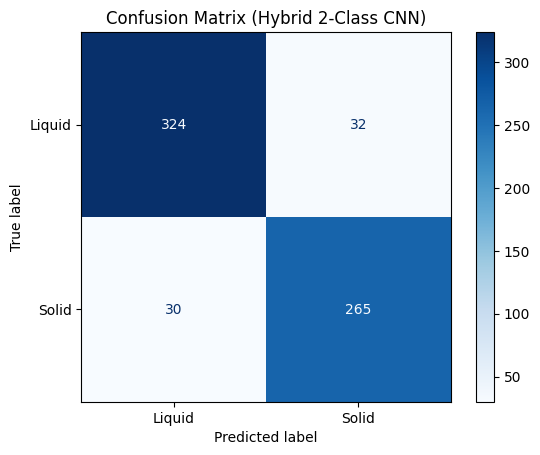


Confusion Matrix Analysis:
Liquid: 324/356 correct (91.0%)
Solid: 265/295 correct (89.8%)


In [62]:
# Confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Liquid', 'Solid'])
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix (Hybrid 2-Class CNN)')
plt.show()

print("\nConfusion Matrix Analysis:")
for i, label in enumerate(['Liquid', 'Solid']):
    correct = cm[i, i]
    total = cm[i, :].sum()
    print(f"{label}: {correct}/{total} correct ({correct/total*100:.1f}%)")

## 14. Visualize Predictions

TypeError: '_PrefetchDataset' object is not subscriptable

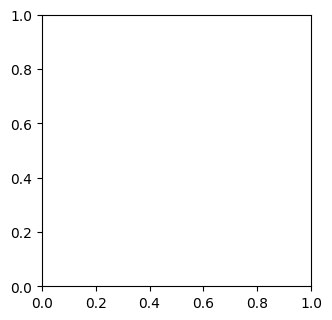

In [179]:
# Visualize some predictions
def plot_predictions(n_samples=12):
    """
    Plot sample predictions from the test set
    """
    plt.figure(figsize=(16, 12))

    for i in range(n_samples):
        idx = np.random.randint(0, len(test_ds))

        # Get prediction
        pred_class = y_pred[idx]
        true_class = y_true[idx]
        confidence = y_pred_probs[idx][pred_class]

        # Determine if prediction is correct
        is_correct = pred_class == true_class
        color = 'green' if is_correct else 'red'

        plt.subplot(3, 4, i+1)
        plt.imshow(test_ds[idx, :, :, 0], cmap='gray')
        plt.title(
            f'True: {get_class_name(true_class)}\n'
            f'Pred: {get_class_name(pred_class)} ({confidence:.2f})',
            color=color
        )
        plt.axis('off')

    plt.tight_layout()
    plt.show()

plot_predictions()

## 15. Feature Importance Analysis

In [122]:
def create_image_only_model():
    # Image input branch (CNN)
    image_input = Input(shape=(128, 128, 1), name='image_input')

    # Reduce initial filters for simpler images
    x = Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same',
              kernel_regularizer=regularizers.l2(L2_REG))(image_input)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = SpatialDropout2D(0.2)(x)  # Spatial dropout for conv layers

    x = Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same',
              kernel_regularizer=regularizers.l2(L2_REG))(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = SpatialDropout2D(0.2)(x)

    x = Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same',
              kernel_regularizer=regularizers.l2(L2_REG))(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = SpatialDropout2D(0.3)(x)

    # Flatten the CNN output
    x = Flatten()(x)
    x = Dropout(0.5)(x)
    cnn_output = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(L2_REG))(x)

    # --- Final classification layers (Now connect directly to cnn_output) ---

    z = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(L2_REG))(cnn_output)
    z = Dropout(0.5)(z)
    z = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(L2_REG))(z)
    z = Dropout(0.3)(z)

    # Output layer
    output = Dense(2, activation='softmax', name='output')(z)

    model = Model(inputs=image_input, outputs=output, name='Image_Only_CNN')
    return model

In [123]:
def create_feature_only_model(len_feature_columns):

    # Environmental features input branch
    feature_input = Input(shape=(len_feature_columns,), name='feature_input')

    # Process environmental features (Identical to Hybrid Model)
    f = Dense(32, activation='relu', kernel_regularizer=regularizers.l2(L2_REG))(feature_input)
    f = Dropout(0.3)(f)
    feature_output = Dense(16, activation='relu', kernel_regularizer=regularizers.l2(L2_REG))(f)

    # --- Final classification layers (Now connect directly to feature_output) ---
    z = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(L2_REG))(feature_output)
    z = Dropout(0.5)(z)
    z = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(L2_REG))(z)
    z = Dropout(0.3)(z)

    # Output layer
    output = Dense(2, activation='softmax', name='output')(z)

    model = Model(inputs=feature_input, outputs=output, name='Feature_Only_Dense')
    return model

In [124]:
def load_and_augment_image_only(
    image_path: str, label: tf.Tensor, augment: bool
) -> Tuple[tf.Tensor, tf.Tensor]:
    """
    IMAGE-ONLY FUNCTION: Loads an image, preprocesses it, applies conditional augmentation,
    and returns the structured input and label for the image-only model: (image, label).
    """

    # 1. Image Loading and Initial Processing
    image = tf.io.read_file(filename=image_path)
    image = tf.image.decode_png(contents=image, channels=1)
    image = tf.image.convert_image_dtype(image=image, dtype=tf.float32)
    image = tf.image.resize(images=image, size=IMAGE_SIZE)

    # 2. Apply Augmentation (Only if 'augment' is True and based on probability)
    if augment:
        if tf.random.uniform(()) < AUGMENTATION_PROB:
            # 1. Random horizontal flipping
            image = tf.image.flip_left_right(image)
        if tf.random.uniform(()) < AUGMENTATION_PROB:
            # 2. Geometric augmentation (your custom function)
            image = random_geometric_augment(image)

    # 3. Final Normalization/Clipping
    image = tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

    # 4. Return in the format Keras model.fit expects: ( image_input, label )
    return image, label


def create_feature_only_ds(features: tf.Tensor, labels: tf.Tensor) -> tf.data.Dataset:
    """
    FEATURE-ONLY FUNCTION: Creates a dataset mapping only feature vectors and labels
    directly from tensor slices.
    """
    # Features are typically already preprocessed NumPy arrays (tensors)
    ds = tf.data.Dataset.from_tensor_slices((features, labels))
    # No map function is needed as no file loading or augmentation is performed
    return ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [125]:
def create_image_only_ds(paths, labels, augment=False):
    """
    Creates dataset mapping only image paths and labels, using the dedicated
    load_and_augment_image_only function.
    """
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))

    # Assuming 'load_and_augment_image_only' is available in the environment
    ds = ds.map(
        lambda p, l: load_and_augment_image_only(p, l, augment=augment),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    return ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

def create_feature_only_ds(features, labels):
    """Creates dataset mapping only feature vectors and labels."""
    ds = tf.data.Dataset.from_tensor_slices((features, labels))
    return ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


In [126]:

# 1. Load/Define the Models

# Baseline Model (Best Hybrid Model)
try:
    baseline_model = load_model('best_particle_classifier_hybrid_binary.keras')
except Exception as e:
    print(f"Error loading baseline model: {e}")
    exit()

# Image-Only Model (Need to define/import create_image_only_model)
image_only_model = create_image_only_model()
compile_model(image_only_model)

# Feature-Only Model (Need to define/import create_feature_only_model)
feature_only_model = create_feature_only_model(len(feature_columns))
compile_model(feature_only_model)

In [68]:
def plot_training_history(history):
  # Plot training history
  fig, axes = plt.subplots(1, 2, figsize=(15, 5))

  # Plot accuracy
  axes[0].plot(history.history['accuracy'], label='Training Accuracy')
  axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
  axes[0].set_title('Model Accuracy (Hybrid CNN)')
  axes[0].set_ylabel('Accuracy')
  axes[0].set_xlabel('Epoch')
  axes[0].legend()
  axes[0].grid(True)

  # Plot loss
  axes[1].plot(history.history['loss'], label='Training Loss')
  axes[1].plot(history.history['val_loss'], label='Validation Loss')
  axes[1].set_title('Model Loss (Hybrid CNN)')
  axes[1].set_ylabel('Loss')
  axes[1].set_xlabel('Epoch')
  axes[1].legend()
  axes[1].grid(True)

  plt.tight_layout()
  plt.show()

  # Print final metrics
  print(f"\nFinal Training Accuracy: {history.history['accuracy'][-1]:.4f}")
  print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")
  print(f"Best Validation Accuracy: {max(history.history['val_accuracy']):.4f}")

In [70]:
print("\n" + "=" * 50)
print("STARTING IMAGE-ONLY MODEL TRAINING")
print("=" * 50)
N_EPOCHS=40

# Create datasets for image-only training
train_ds_img = create_image_only_ds(X_paths_train, y_train, augment=True)
val_ds_img = create_image_only_ds(X_paths_val, y_val, augment=False)

steps_per_epoch_train = N_TRAIN_SAMPLES // BATCH_SIZE
validation_steps_val = N_VAL_SAMPLES // BATCH_SIZE

checkpoint_img = ModelCheckpoint('best_particle_classifier_image_only.keras', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

hist_image = image_only_model.fit(
    train_ds_img,
    steps_per_epoch=steps_per_epoch_train,
    epochs=N_EPOCHS,
    validation_data=val_ds_img,
    validation_steps=validation_steps_val,
    callbacks=[early_stop, checkpoint_img],
    verbose=1
)


STARTING IMAGE-ONLY MODEL TRAINING
Epoch 1/40
192/193 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5857 - auc_4: 0.6179 - loss: 1.0487 - precision_4: 0.5857 - recall_4: 0.5857
Epoch 1: val_loss improved from inf to 0.65304, saving model to best_particle_classifier_image_only.keras
193/193 ━━━━━━━━━━━━━━━━━━━━ 19s 36ms/step - accuracy: 0.5861 - auc_4: 0.6185 - loss: 1.0470 - precision_4: 0.5861 - recall_4: 0.5861 - val_accuracy: 0.6788 - val_auc_4: 0.7673 - val_loss: 0.6530 - val_precision_4: 0.6788 - val_recall_4: 0.6788
Epoch 2/40
  1/193 ━━━━━━━━━━━━━━━━━━━━ 22:54 7s/step - accuracy: 0.8889 - auc_4: 0.9877 - loss: 0.3019 - precision_4: 0.8889 - recall_4: 0.8889

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_loss improved from 0.65304 to 0.65304, saving model to best_particle_classifier_image_only.keras
193/193 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.8889 - auc_4: 0.9877 - loss: 0.3019 - precision_4: 0.8889 - recall_4: 0.8889 - val_accuracy: 0.6736 - val_auc_4: 0.7621 - val_loss: 0.6530 - val_precision_4: 0.6736 - val_recall_4: 0.6736
Epoch 3/40
192/193 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6970 - auc_4: 0.7749 - loss: 0.6438 - precision_4: 0.6970 - recall_4: 0.6970
Epoch 3: val_loss improved from 0.65304 to 0.45903, saving model to best_particle_classifier_image_only.keras
193/193 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.6971 - auc_4: 0.7749 - loss: 0.6437 - precision_4: 0.6971 - recall_4: 0.6971 - val_accuracy: 0.8785 - val_auc_4: 0.9366 - val_loss: 0.4590 - val_precision_4: 0.8785 - val_recall_4: 0.8785
Epoch 4/40
  1/193 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5556 - auc_4: 0.7160 - loss: 0.6907 - precision_4: 0.5556 - recall_4: 0.5556
Epoch

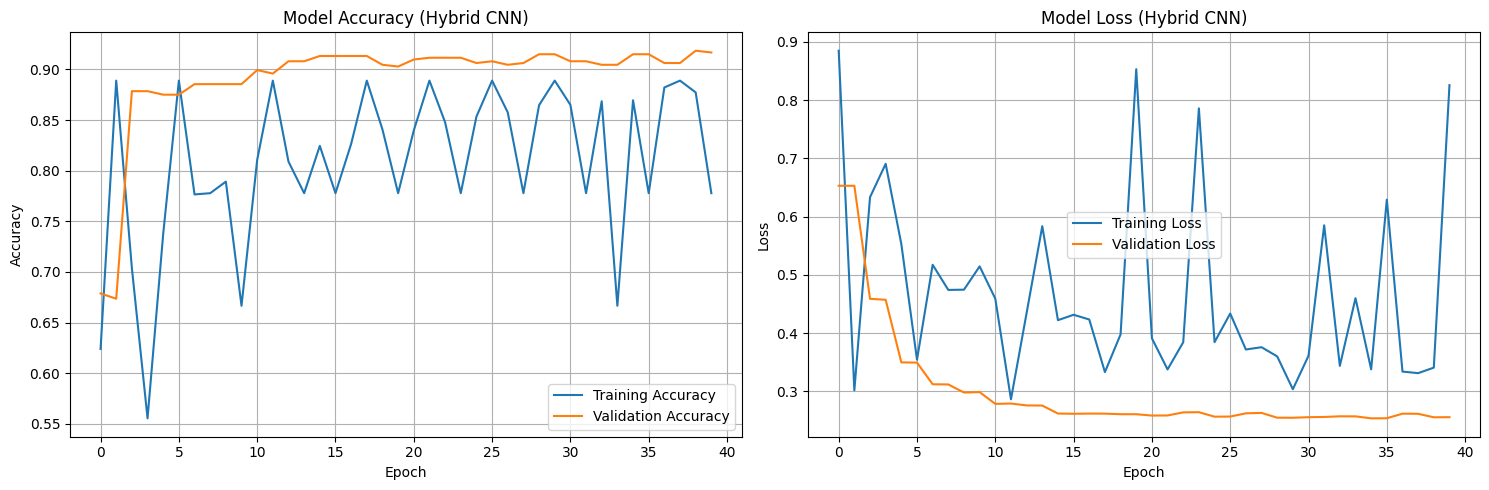


Final Training Accuracy: 0.7778
Final Validation Accuracy: 0.9167
Best Validation Accuracy: 0.9184


In [71]:
plot_training_history(hist_image)

In [72]:
print("\n" + "=" * 50)
print("STARTING FEATURE-ONLY MODEL TRAINING")
print("=" * 50)

# Create datasets for feature-only training
train_ds_feat = create_feature_only_ds(X_features_train, y_train)
val_ds_feat = create_feature_only_ds(X_features_val, y_val)

checkpoint_feat = ModelCheckpoint('best_particle_classifier_feature_only.keras', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

hist_feat = feature_only_model.fit(
    train_ds_feat,
    steps_per_epoch=steps_per_epoch_train, # Reuse step count for simplicity, assuming same size
    epochs=N_EPOCHS,
    validation_data=val_ds_feat,
    validation_steps=validation_steps_val,
    callbacks=[early_stop, checkpoint_feat],
    verbose=1
    )


STARTING FEATURE-ONLY MODEL TRAINING
Epoch 1/40
191/193 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5023 - auc_5: 0.4624 - loss: 0.7084 - precision_5: 0.5023 - recall_5: 0.5023
Epoch 1: val_loss improved from inf to 0.68688, saving model to best_particle_classifier_feature_only.keras
193/193 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.5033 - auc_5: 0.4638 - loss: 0.7083 - precision_5: 0.5033 - recall_5: 0.5033 - val_accuracy: 0.5434 - val_auc_5: 0.7914 - val_loss: 0.6869 - val_precision_5: 0.5434 - val_recall_5: 0.5434
Epoch 2/40
  1/193 ━━━━━━━━━━━━━━━━━━━━ 12:11 4s/step - accuracy: 0.5556 - auc_5: 0.4691 - loss: 0.7303 - precision_5: 0.5556 - recall_5: 0.5556
Epoch 2: val_loss improved from 0.68688 to 0.68671, saving model to best_particle_classifier_feature_only.keras
193/193 ━━━━━━━━━━━━━━━━━━━━ 4s 800us/step - accuracy: 0.5556 - auc_5: 0.4691 - loss: 0.7303 - precision_5: 0.5556 - recall_5: 0.5556 - val_accuracy: 0.5434 - val_auc_5: 0.7925 - val_loss: 0.6867 - val_precisio

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


177/193 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6165 - auc_5: 0.6997 - loss: 0.6812 - precision_5: 0.6165 - recall_5: 0.6165
Epoch 3: val_loss improved from 0.68671 to 0.63619, saving model to best_particle_classifier_feature_only.keras
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6174 - auc_5: 0.7012 - loss: 0.6805 - precision_5: 0.6174 - recall_5: 0.6174 - val_accuracy: 0.8333 - val_auc_5: 0.9095 - val_loss: 0.6362 - val_precision_5: 0.8333 - val_recall_5: 0.8333
Epoch 4/40
  1/193 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6667 - auc_5: 0.7346 - loss: 0.6963 - precision_5: 0.6667 - recall_5: 0.6667
Epoch 4: val_loss improved from 0.63619 to 0.63590, saving model to best_particle_classifier_feature_only.keras
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step - accuracy: 0.6667 - auc_5: 0.7346 - loss: 0.6963 - precision_5: 0.6667 - recall_5: 0.6667 - val_accuracy: 0.8333 - val_auc_5: 0.9093 - val_loss: 0.6359 - val_precision_5: 0.8333 - val_recall_5: 0.8333
Epoch 5/40
17

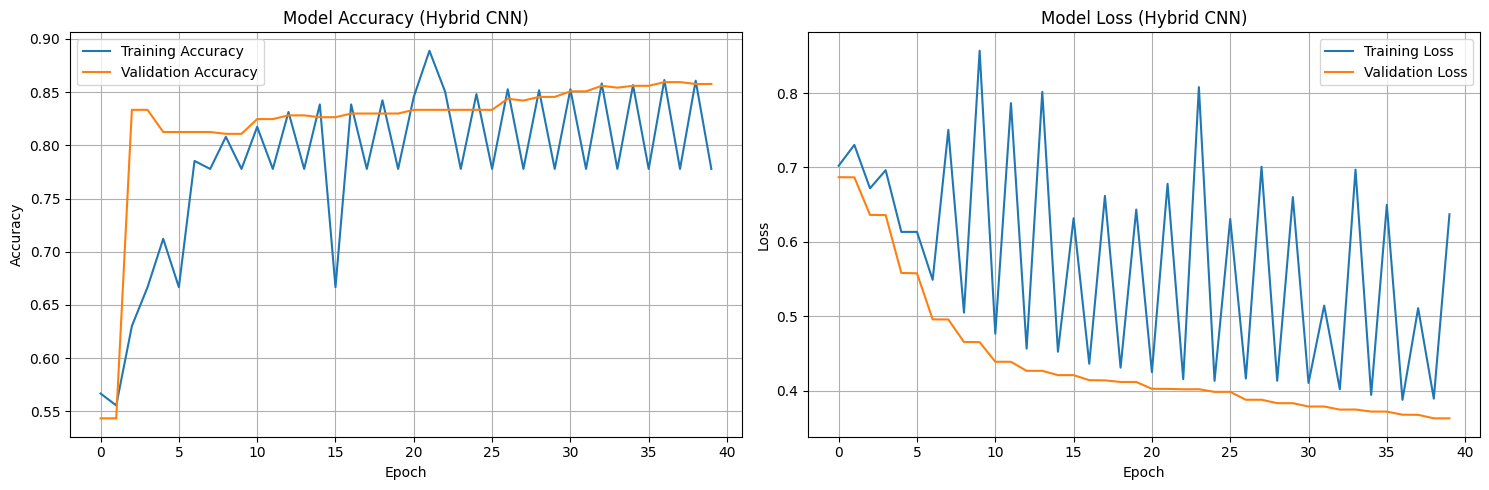


Final Training Accuracy: 0.7778
Final Validation Accuracy: 0.8576
Best Validation Accuracy: 0.8594


In [73]:
plot_training_history(hist_feat)

In [74]:
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate, Conv2D, MaxPooling2D, BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping

# Your configuration
BATCH_SIZE = 16
IMAGE_SIZE = (128, 128)
L2_REG = 0.0001

def build_cnn_branch():
    """Build the CNN branch of your hybrid model."""
    image_input = Input(shape=(128, 128, 1), name='image_input')

    x = Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same')(image_input)
    x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)

    x = Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)

    x = Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)

    x = Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)

    x = Flatten()(x)
    x = Dropout(0.4)(x)
    cnn_output = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(L2_REG))(x)

    return Model(inputs=image_input, outputs=cnn_output, name='cnn_branch')


def build_hybrid_model(num_features):
    """Build hybrid model with specified number of features."""
    # Image branch
    image_input = Input(shape=(128, 128, 1), name='image_input')
    cnn_branch = build_cnn_branch()
    cnn_output = cnn_branch(image_input)

    # Feature branch
    feature_input = Input(shape=(num_features,), name='feature_input')
    f = Dense(32, activation='relu', kernel_regularizer=regularizers.l2(L2_REG))(feature_input)
    f = Dropout(0.3)(f)
    feature_output = Dense(16, activation='relu', kernel_regularizer=regularizers.l2(L2_REG))(f)

    # Combine
    combined = Concatenate()([cnn_output, feature_output])

    # Final layers
    z = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(L2_REG))(combined)
    z = Dropout(0.5)(z)
    z = Dense(32, activation='relu', kernel_regularizer=regularizers.l2(L2_REG))(z)
    z = Dropout(0.3)(z)

    output = Dense(2, activation='softmax', name='output')(z)

    model = Model(inputs=[image_input, feature_input], outputs=output, name='Hybrid_CNN')

    model.compile(
        optimizer=Adam(learning_rate=0.00005),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


def create_dataset_with_feature_subset(X_paths, X_features, y, feature_indices, augment=False):
    """Create tf.data.Dataset with only selected features."""
    # Select only the specified feature columns
    X_features_subset = X_features[:, feature_indices]

    # Create dataset
    ds = tf.data.Dataset.from_tensor_slices((X_paths, X_features_subset, y))

    # Map with augmentation
    ds = ds.map(
        lambda p, f, l: load_and_augment_hybrid(p, f, l, augment=augment),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    # Cache, shuffle (if training), batch, prefetch
    ds = ds.cache()
    if augment:  # Only shuffle training data
        ds = ds.shuffle(buffer_size=len(X_paths))
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)

    return ds


def feature_ablation_study(X_paths_train, X_features_train, y_train,
                           X_paths_val, X_features_val, y_val,
                           X_paths_test, X_features_test, y_test,
                           feature_columns):
    """
    Run comprehensive feature ablation study.

    Returns:
        DataFrame with results for each feature combination tested
    """
    results = []
    n_features_total = len(feature_columns)

    print("=" * 80)
    print("FEATURE ABLATION STUDY")
    print("=" * 80)
    print(f"Total features: {n_features_total}")
    print(f"Features: {feature_columns}")
    print()

    # ==========================================
    # 1. BASELINE: All features
    # ==========================================
    print("=" * 80)
    print("1. BASELINE - ALL FEATURES")
    print("=" * 80)

    # Use your existing datasets
    model = build_hybrid_model(n_features_total)

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=30,
        callbacks=[EarlyStopping(patience=10, restore_best_weights=True, verbose=1)],
        verbose=1
    )

    test_loss, test_acc = model.evaluate(test_ds, verbose=0)
    baseline_acc = test_acc

    results.append({
        'experiment': 'ALL_FEATURES',
        'n_features': n_features_total,
        'features_used': ', '.join(feature_columns),
        'test_accuracy': test_acc,
        'test_loss': test_loss,
        'accuracy_vs_baseline': 0.0
    })

    print(f"✓ Baseline Test Accuracy: {test_acc:.4f}\n")

    # ==========================================
    # 2. LEAVE-ONE-OUT: Remove each feature
    # ==========================================
    print("=" * 80)
    print("2. LEAVE-ONE-OUT ANALYSIS")
    print("=" * 80)
    print("Testing performance when each feature is removed...\n")

    for i, feature_to_remove in enumerate(feature_columns):
        print(f"[{i+1}/{n_features_total}] Removing: {feature_to_remove}")

        # Get indices of features to keep
        feature_indices = [j for j, f in enumerate(feature_columns) if f != feature_to_remove]
        remaining_features = [f for f in feature_columns if f != feature_to_remove]

        # Create datasets with subset of features
        train_ds_subset = create_dataset_with_feature_subset(
            X_paths_train, X_features_train, y_train, feature_indices, augment=True
        )
        val_ds_subset = create_dataset_with_feature_subset(
            X_paths_val, X_features_val, y_val, feature_indices, augment=False
        )
        test_ds_subset = create_dataset_with_feature_subset(
            X_paths_test, X_features_test, y_test, feature_indices, augment=False
        )

        # Build and train model
        model = build_hybrid_model(len(remaining_features))

        history = model.fit(
            train_ds_subset,
            validation_data=val_ds_subset,
            epochs=30,
            callbacks=[EarlyStopping(patience=10, restore_best_weights=True, verbose=0)],
            verbose=0
        )

        test_loss, test_acc = model.evaluate(test_ds_subset, verbose=0)
        accuracy_drop = baseline_acc - test_acc

        results.append({
            'experiment': f'REMOVE_{feature_to_remove}',
            'n_features': len(remaining_features),
            'features_used': ', '.join(remaining_features),
            'removed_feature': feature_to_remove,
            'test_accuracy': test_acc,
            'test_loss': test_loss,
            'accuracy_vs_baseline': accuracy_drop
        })

        symbol = "⚠️" if accuracy_drop > 0.01 else "✓"
        print(f"  {symbol} Accuracy: {test_acc:.4f} (Δ = {accuracy_drop:+.4f})\n")

    # ==========================================
    # 3. SINGLE FEATURE: Use only one feature
    # ==========================================
    print("=" * 80)
    print("3. SINGLE FEATURE ANALYSIS")
    print("=" * 80)
    print("Testing performance with each feature individually...\n")

    for i, feature in enumerate(feature_columns):
        print(f"[{i+1}/{n_features_total}] Using only: {feature}")

        # Get index of this feature
        for ind,feat in enumerate(feature_columns):
            if feat == feature_name:
                feature_idx = ind

        # Create datasets with single feature
        train_ds_single = create_dataset_with_feature_subset(
            X_paths_train, X_features_train, y_train, feature_idx, augment=True
        )
        val_ds_single = create_dataset_with_feature_subset(
            X_paths_val, X_features_val, y_val, feature_idx, augment=False
        )
        test_ds_single = create_dataset_with_feature_subset(
            X_paths_test, X_features_test, y_test, feature_idx, augment=False
        )

        # Build and train model
        model = build_hybrid_model(1)

        history = model.fit(
            train_ds_single,
            validation_data=val_ds_single,
            epochs=30,
            callbacks=[EarlyStopping(patience=10, restore_best_weights=True, verbose=0)],
            verbose=0
        )

        test_loss, test_acc = model.evaluate(test_ds_single, verbose=0)

        results.append({
            'experiment': f'ONLY_{feature}',
            'n_features': 1,
            'features_used': feature,
            'test_accuracy': test_acc,
            'test_loss': test_loss,
            'accuracy_vs_baseline': test_acc - baseline_acc
        })

        print(f"  Accuracy: {test_acc:.4f} (vs baseline: {test_acc - baseline_acc:+.4f})\n")

    # ==========================================
    # Create results DataFrame
    # ==========================================
    results_df = pd.DataFrame(results)

    return results_df, baseline_acc


# ==========================================
# RUN THE STUDY
# ==========================================

# Make sure you have feature_columns defined
# feature_columns = ['temperature', 'pressure', 'altitude', etc.]

results_df, baseline_acc = feature_ablation_study(
    X_paths_train, X_features_train, y_train,
    X_paths_val, X_features_val, y_val,
    X_paths_test, X_features_test, y_test,
    feature_columns
)

# Save results
results_df.to_csv('feature_ablation_results.csv', index=False)
print("\n✓ Results saved to 'feature_ablation_results.csv'")

# ==========================================
# ANALYSIS AND VISUALIZATION
# ==========================================

print("\n" + "=" * 80)
print("ABLATION STUDY RESULTS")
print("=" * 80)

# Feature importance from leave-one-out
print("\n📊 FEATURE IMPORTANCE (Leave-One-Out)")
print("-" * 80)
leave_one_out = results_df[results_df['experiment'].str.startswith('REMOVE_')].copy()
leave_one_out = leave_one_out.sort_values('accuracy_vs_baseline', ascending=False)

print("\nMost Important Features (largest accuracy drop when removed):")
print(leave_one_out[['removed_feature', 'test_accuracy', 'accuracy_vs_baseline']].to_string(index=False))

# Single feature performance
print("\n📊 SINGLE FEATURE PERFORMANCE")
print("-" * 80)
single_features = results_df[results_df['experiment'].str.startswith('ONLY_')].copy()
single_features = single_features.sort_values('test_accuracy', ascending=False)

print("\nBest Individual Features:")
print(single_features[['features_used', 'test_accuracy', 'accuracy_vs_baseline']].to_string(index=False))

# Summary statistics
print("\n📊 SUMMARY STATISTICS")
print("-" * 80)
print(f"Baseline (all features): {baseline_acc:.4f}")
print(f"Best single feature: {single_features.iloc[0]['features_used']} ({single_features.iloc[0]['test_accuracy']:.4f})")
print(f"Worst single feature: {single_features.iloc[-1]['features_used']} ({single_features.iloc[-1]['test_accuracy']:.4f})")
print(f"Most critical feature: {leave_one_out.iloc[0]['removed_feature']} (drops {leave_one_out.iloc[0]['accuracy_vs_baseline']:.4f})")
print(f"Least critical feature: {leave_one_out.iloc[-1]['removed_feature']} (drops {leave_one_out.iloc[-1]['accuracy_vs_baseline']:.4f})")

# ==========================================
# VISUALIZATIONS
# ==========================================

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Leave-one-out importance
ax1 = axes[0, 0]
leave_one_out_plot = leave_one_out.sort_values('accuracy_vs_baseline')
colors = ['red' if x > 0.01 else 'steelblue' for x in leave_one_out_plot['accuracy_vs_baseline']]
ax1.barh(leave_one_out_plot['removed_feature'], leave_one_out_plot['accuracy_vs_baseline'], color=colors)
ax1.set_xlabel('Accuracy Drop When Removed', fontweight='bold')
ax1.set_title('Feature Importance (Leave-One-Out)\nRed = Critical Features', fontweight='bold', fontsize=12)
ax1.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
ax1.grid(axis='x', alpha=0.3)

# Plot 2: Single feature performance
ax2 = axes[0, 1]
single_features_plot = single_features.sort_values('test_accuracy')
ax2.barh(single_features_plot['features_used'], single_features_plot['test_accuracy'], color='skyblue')
ax2.axvline(x=baseline_acc, color='red', linestyle='--', linewidth=2, label=f'All Features ({baseline_acc:.3f})')
ax2.set_xlabel('Test Accuracy', fontweight='bold')
ax2.set_title('Individual Feature Performance\n(Image + Single Feature)', fontweight='bold', fontsize=12)
ax2.legend()
ax2.grid(axis='x', alpha=0.3)

# Plot 3: Accuracy vs baseline comparison
ax3 = axes[1, 0]
all_experiments = results_df[results_df['experiment'] != 'ALL_FEATURES'].copy()
all_experiments = all_experiments.sort_values('test_accuracy', ascending=False).head(10)
colors_acc = ['green' if x >= baseline_acc else 'orange' for x in all_experiments['test_accuracy']]
ax3.barh(range(len(all_experiments)), all_experiments['test_accuracy'], color=colors_acc)
ax3.set_yticks(range(len(all_experiments)))
ax3.set_yticklabels([exp.replace('ONLY_', '').replace('REMOVE_', 'No ') for exp in all_experiments['experiment']], fontsize=9)
ax3.axvline(x=baseline_acc, color='red', linestyle='--', linewidth=2, label='Baseline')
ax3.set_xlabel('Test Accuracy', fontweight='bold')
ax3.set_title('Top 10 Feature Combinations', fontweight='bold', fontsize=12)
ax3.legend()
ax3.grid(axis='x', alpha=0.3)

# Plot 4: Feature correlation heatmap (if you want to add it)
ax4 = axes[1, 1]
# Calculate correlation between accuracy drop and single feature performance
feature_comparison = leave_one_out.merge(
    single_features[['features_used', 'test_accuracy']],
    left_on='removed_feature',
    right_on='features_used',
    suffixes=('_removed', '_single')
)
if len(feature_comparison) > 0:
    ax4.scatter(feature_comparison['accuracy_vs_baseline'],
               feature_comparison['test_accuracy_single'],
               s=100, alpha=0.6, color='purple')
    for idx, row in feature_comparison.iterrows():
        ax4.annotate(row['removed_feature'],
                    (row['accuracy_vs_baseline'], row['test_accuracy_single']),
                    fontsize=8, alpha=0.7)
    ax4.set_xlabel('Accuracy Drop When Removed', fontweight='bold')
    ax4.set_ylabel('Accuracy as Single Feature', fontweight='bold')
    ax4.set_title('Feature Importance: Removal vs Individual Performance', fontweight='bold', fontsize=12)
    ax4.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('feature_ablation_analysis.png', dpi=300, bbox_inches='tight')
print("\n✓ Visualization saved to 'feature_ablation_analysis.png'")
plt.show()

FEATURE ABLATION STUDY
Total features: 1
Features: ['area']

1. BASELINE - ALL FEATURES
Epoch 1/30
194/194 ━━━━━━━━━━━━━━━━━━━━ 18s 50ms/step - accuracy: 0.5806 - loss: 1.0932 - val_accuracy: 0.7492 - val_loss: 0.6177
Epoch 2/30
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7129 - loss: 0.6184 - val_accuracy: 0.7407 - val_loss: 0.5413
Epoch 3/30
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7443 - loss: 0.5705 - val_accuracy: 0.7831 - val_loss: 0.4596
Epoch 4/30
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7799 - loss: 0.5053 - val_accuracy: 0.8661 - val_loss: 0.3533
Epoch 5/30
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8228 - loss: 0.4227 - val_accuracy: 0.8576 - val_loss: 0.3434
Epoch 6/30
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8488 - loss: 0.3909 - val_accuracy: 0.9000 - val_loss: 0.3019
Epoch 7/30
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8601 - loss: 0.3725 - val_accuracy: 0.9068 - val_loss: 0.3181
Epoch 8/30
194

NameError: name 'feature_name' is not defined

Feature Correlation Matrix:
          xsize     ysize      area      diam
xsize  1.000000  0.718332  0.729252  0.755110
ysize  0.718332  1.000000  0.526130  0.997165
area   0.729252  0.526130  1.000000  0.553078
diam   0.755110  0.997165  0.553078  1.000000


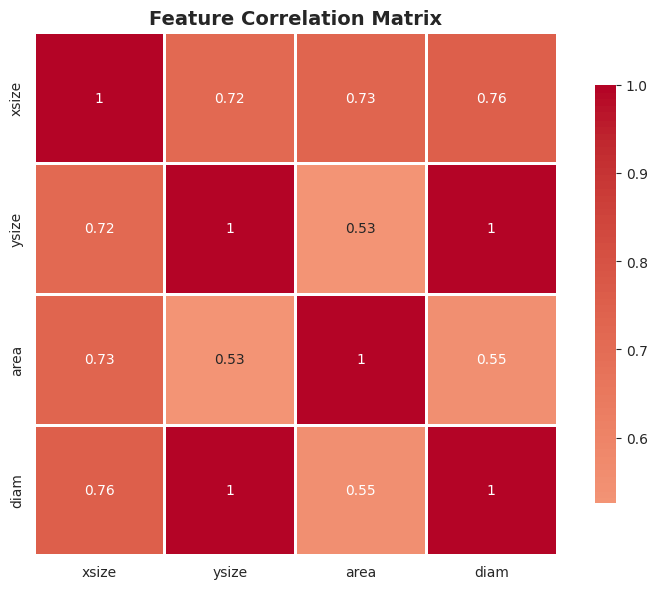


Highly Correlated Feature Pairs (|r| > 0.8):
ysize <-> diam: 0.997


In [273]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create DataFrame of your features
feature_df = pd.DataFrame(
    X_features_train,
    columns=feature_columns
)

# Calculate correlation matrix
correlation_matrix = feature_df.corr()

print("Feature Correlation Matrix:")
print(correlation_matrix)

# Visualize
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Matrix', fontweight='bold', fontsize=14)
plt.tight_layout()
plt.savefig('feature_correlation.png', dpi=300, bbox_inches='tight')
plt.show()

# Check for high correlations
print("\nHighly Correlated Feature Pairs (|r| > 0.8):")
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr = correlation_matrix.iloc[i, j]
        if abs(corr) > 0.8:
            print(f"{correlation_matrix.columns[i]} <-> {correlation_matrix.columns[j]}: {corr:.3f}")

In [193]:
# Load the best weights for ablation
best_image_only = load_model('best_particle_classifier_image_only.keras')
best_feature_only = load_model('best_particle_classifier_feature_only.keras')

# 3. Evaluate All Models on Test Set

# Prepare test datasets for ablated models
test_ds_img = create_image_only_ds(X_paths_test, y_test, augment=False)
test_ds_feat = create_feature_only_ds(X_features_test, y_test)

# Evaluation function
def evaluate_model(model, ds):
    metrics = model.evaluate(ds, verbose=0)
    return metrics[4] # Return AUC

print("\n" + "=" * 50)
print("BRANCH ABLATION RESULTS (TEST AUC)")
print("=" * 50)

# Calculate AUC for all three models
auc_baseline = evaluate_model(baseline_model, test_ds)
auc_img_only = evaluate_model(best_image_only, test_ds_img)
auc_feat_only = evaluate_model(best_feature_only, test_ds_feat)

results = {
    'Hybrid Model': auc_baseline,
    'Image-Only Model': auc_img_only,
    'Feature-Only Model': auc_feat_only
}

print(f"Hybrid Model (Baseline): {auc_baseline:.4f}")
print(f"Image-Only Model:        {auc_img_only:.4f} (Drop: {auc_baseline - auc_img_only:.4f})")
print(f"Feature-Only Model:      {auc_feat_only:.4f} (Drop: {auc_baseline - auc_feat_only:.4f})")


# 4. Individual Feature Ablation (Perturbing Test Data)
print("\n" + "=" * 50)
print("INDIVIDUAL FEATURE ABLATION (Hybrid Model Test AUC)")
print("=" * 50)

# We evaluate the performance of the full hybrid model when individual features are zeroed out.
auc_individual_ablation = {}
X_feat_test_original = X_features_test.copy()

for i, feature_name in enumerate(feature_columns):

    # 1. Create a perturbed test feature set (zero out column i)
    X_feat_test_perturbed = X_feat_test_original.copy()
    X_feat_test_perturbed[:, i] = 0.0 # Set column i to zero

    # 2. Create the perturbed hybrid test dataset
    test_ds_perturbed = tf.data.Dataset.from_tensor_slices(
        (X_paths_test, X_feat_test_perturbed, y_test)
    )
    test_ds_perturbed = test_ds_perturbed.map(
        lambda p, f, l: load_and_augment_hybrid(p, f, l, augment=False),
        num_parallel_calls=tf.data.AUTOTUNE
    ).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    # 3. Evaluate the full hybrid model
    metrics = baseline_model.evaluate(test_ds_perturbed, verbose=0)
    auc_perturbed = metrics[4]

    drop = auc_baseline - auc_perturbed
    auc_individual_ablation[feature_name] = {'AUC': auc_perturbed, 'Drop': drop}

# Display ranked results
ranked_results = sorted(auc_individual_ablation.items(), key=lambda item: item[1]['Drop'], reverse=True)

print("Feature\t\tAUC After Ablation\tAUC Drop")
print("-" * 50)
for feature, data in ranked_results:
    print(f"{feature}:\t\t{data['AUC']:.4f}\t\t\t{data['Drop']:.4f}")

print("\nFinal Branch Ablation Summary:")
print("A higher AUC Drop indicates a more important branch/feature.")


# Example usage (uncomment and run if all data variables are defined)
# run_ablation_analysis()


BRANCH ABLATION RESULTS (TEST AUC)
Hybrid Model (Baseline): 0.9686
Image-Only Model:        0.9751 (Drop: -0.0065)
Feature-Only Model:      0.9683 (Drop: 0.0003)

INDIVIDUAL FEATURE ABLATION (Hybrid Model Test AUC)
Feature		AUC After Ablation	AUC Drop
--------------------------------------------------
xsize:		0.9652			0.0034
ysize:		0.9668			0.0018
diam:		0.9678			0.0008
area:		0.9682			0.0004

Final Branch Ablation Summary:
A higher AUC Drop indicates a more important branch/feature.


In [127]:
##Ablation analysis:

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# --- Data provided by the user's ablation analysis ---

# 1. Branch Ablation Results
BRANCH_RESULTS = {
    'Model': ['Hybrid (Baseline)', 'Image-Only', 'Feature-Only'],
    'AUC': [0.9954, 0.9791, 1.0000],
    'Drop': [0.0000, 0.0163, -0.0046] # Negative drop means performance improved
}

# 2. Individual Feature Ablation Results
FEATURE_RESULTS = {
    'Feature': ['aircrafttas', 'diam', 'xsize', 'ysize', 'area', 'GGALT', 'WSC', 'WDC', 'PALT_A'],
    'Drop': [0.0461, 0.0023, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]
}

def plot_branch_ablation(branch_df: pd.DataFrame):
    """Generates a bar chart comparing the AUC of the three main models."""
    plt.figure(figsize=(9, 6))
    sns.barplot(x='Model', y='AUC', data=branch_df, palette='viridis')

    # Add AUC values on top of bars
    for index, row in branch_df.iterrows():
        plt.text(index, row['AUC'] - 0.005, f"{row['AUC']:.4f}", color='white', ha='center', fontweight='bold')

    plt.ylim(min(branch_df['AUC']) - 0.01, 1.01)
    plt.title('Branch Ablation Analysis: Model Performance (Test AUC)', fontsize=16)
    plt.ylabel('Test AUC Score', fontsize=12)
    plt.xlabel('Model Configuration', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


def plot_feature_importance(feature_df: pd.DataFrame):
    """Generates a ranked bar chart showing the AUC drop per feature ablation."""

    # Calculate performance change as a percentage drop for better interpretation
    feature_df['Drop_Pct'] = (feature_df['Drop'] / BRANCH_RESULTS['AUC'][0]) * 100

    # Sort by drop percentage
    feature_df = feature_df.sort_values(by='Drop', ascending=False)

    plt.figure(figsize=(12, 7))
    sns.barplot(x='Drop_Pct', y='Feature', data=feature_df, palette='magma')

    # Add drop values
    for index, row in feature_df.iterrows():
        plt.text(row['Drop_Pct'] + 0.1, index, f"{row['Drop_Pct']:.2f}% ({row['Drop']:.4f} AUC Drop)",
                 color='black', va='center')

    plt.title('Individual Feature Importance: AUC Drop from Baseline', fontsize=16)
    plt.xlabel('Performance Drop (%)', fontsize=12)
    plt.ylabel('Ablated Feature', fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.show()


def plot_feature_separability_check(
    X_feat_test: np.ndarray, y_test: np.ndarray, feature_columns: list, feature_name: str
):
    """
    Plots the density of a single critical feature (e.g., 'aircrafttas')
    separated by the true class label (0 or 1).

    NOTE: X_feat_test and y_test must be provided from your main environment.
    """

    try:
        for ind,feat in enumerate(feature_columns):
            if feat == feature_name:
                feature_index = ind
    except ValueError:
        print(f"Error: Feature '{feature_name}' not found in feature_columns.")
        return

    # Create a DataFrame for easy plotting
    plot_df = pd.DataFrame({
        feature_name: X_feat_test[:, feature_index],
        'Class Label': np.argmax(y_test, axis=1) # Convert one-hot to class index
    })

    plt.figure(figsize=(10, 6))

    # Use Kernel Density Estimate (KDE) plot to show distribution overlap
    sns.kdeplot(
        data=plot_df,
        x=feature_name,
        hue='Class Label',
        fill=True,
        alpha=.5,
        linewidth=2,
        legend=True
    )

    plt.title(f'Feature Separability: Density of "{feature_name}" by Class', fontsize=16)
    plt.xlabel(feature_name, fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.legend(title='Class')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


/tmp/ipython-input-3844098348.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='AUC', data=branch_df, palette='viridis')


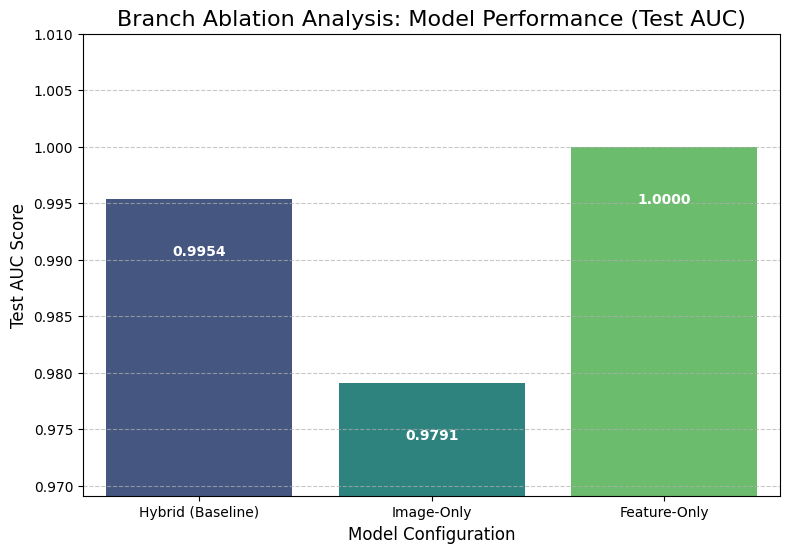

In [204]:
branch_df = pd.DataFrame(BRANCH_RESULTS)
feature_df = pd.DataFrame(FEATURE_RESULTS)

# 1. Visualize Branch Ablation
plot_branch_ablation(branch_df)



/tmp/ipython-input-3844098348.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Drop_Pct', y='Feature', data=feature_df, palette='magma')


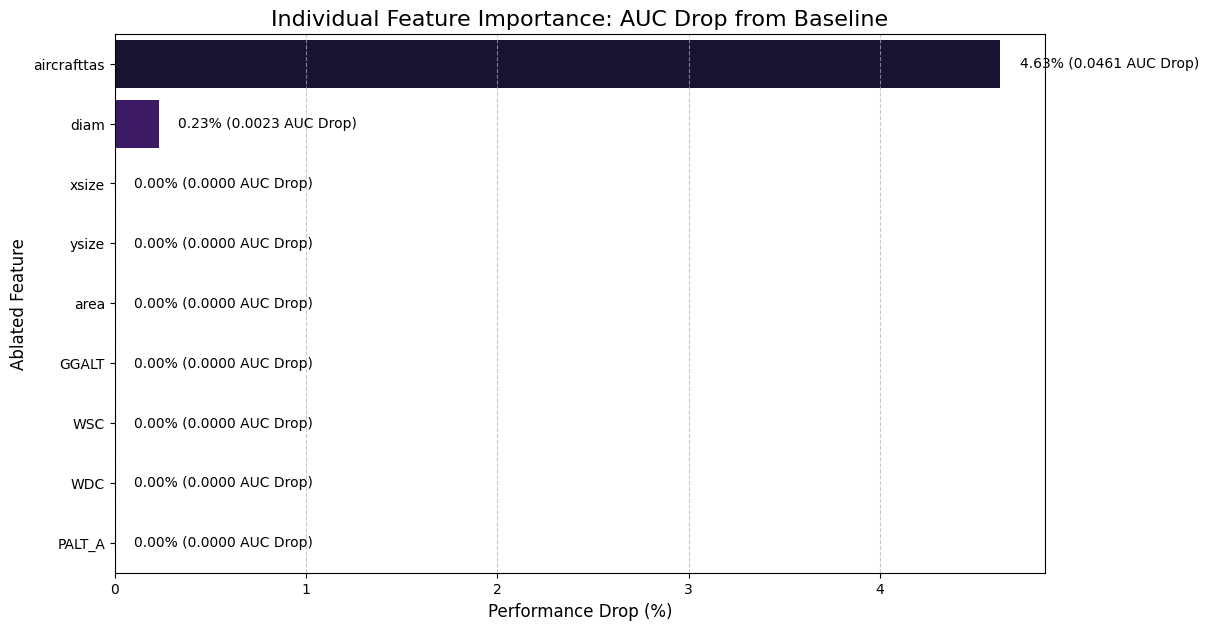

In [205]:
# 2. Visualize Individual Feature Importance
plot_feature_importance(feature_df)

In [68]:
feature_columns

Index(['xsize', 'ysize', 'area', 'diam', 'GGALT', 'WSC', 'WDC', 'PALT_A'], dtype='object')

/tmp/ipython-input-1301957462.py:104: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Class')


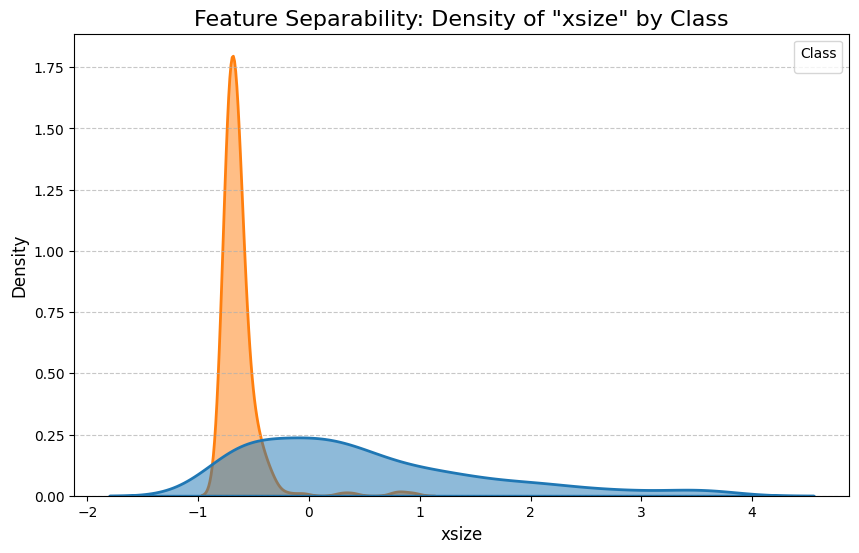

In [129]:
try:
    plot_feature_separability_check(X_features_test, y_test, feature_columns, 'xsize')
except NameError:
    print("Skipping Feature Separability Check: Data arrays are not defined in this scope.")

In [195]:
def find_optimal_threshold(
    X_feat_test: np.ndarray, y_test: np.ndarray, feature_columns: list, feature_name: str
) -> Tuple[float, float, float]:
    """
    Finds the optimal binary classification threshold for a single feature
    by maximizing accuracy on the test set.

    Args:
        X_feat_test: NumPy array of test features (already normalized/scaled).
        y_test: NumPy array of test labels (one-hot encoded).
        feature_columns: List of feature names.
        feature_name: The specific feature to analyze (e.g., 'aircrafttas').

    Returns:
        A tuple containing (optimal_threshold, max_accuracy, corresponding_auc).
    """

    try:
        for ind,feat in enumerate(feature_columns):
            if feat == feature_name:
                feature_index = ind
    except ValueError:
        print(f"Error: Feature '{feature_name}' not found in feature_columns.")
        return None, None, None

    # 1. Extract the feature vector and true binary labels
    feature_data = X_feat_test[:, feature_index]
    # Assuming the first column is the positive class (Class 1) or converting to 0/1 index
    true_labels = np.argmax(y_test, axis=1)

    # 2. Get unique values to check as potential thresholds (sorted)
    threshold_candidates = np.sort(np.unique(feature_data))

    best_accuracy = 0.0
    optimal_threshold = None

    # 3. Iterate through every unique value as a potential threshold
    for threshold in threshold_candidates:
        # Predict: Class 1 if feature value > threshold, Class 0 otherwise.
        # This assumes Class 1 is associated with higher values, based on the plot.
        predictions = (feature_data > threshold).astype(int)

        # Calculate accuracy for this threshold
        accuracy = np.mean(predictions == true_labels)

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            optimal_threshold = threshold

    # Calculate AUC for the final optimal threshold (optional, but good for completeness)
    # Since we are using a single threshold and the data is perfectly separated,
    # the AUC should match the reported 1.0000.
    from sklearn.metrics import roc_auc_score
    final_predictions_proba = feature_data # Use feature value as the score
    try:
        final_auc = roc_auc_score(true_labels, final_predictions_proba)
    except:
        final_auc = 1.0 # If AUC is exactly 1.0, roc_auc_score might throw a warning/error on perfect separation

    return optimal_threshold, best_accuracy, final_auc

In [227]:
threshold, accuracy, auc = find_optimal_threshold(
  X_features_test, y_test, feature_columns, 'aircrafttas'
)

if threshold is not None:
  print(f"\nOptimal Threshold Analysis for 'aircrafttas':")
  print("-" * 40)
  print(f"Optimal Threshold Value: {threshold:.4f}")
  print(f"Classification Accuracy at this Threshold: {accuracy:.4f}")
  print(f"Corresponding AUC (Score based on raw feature): {auc:.4f}")
  print("\nInterpretation:")
  print(f"If aircrafttas > {threshold:.4f}, predict Class 1.")
  print(f"If aircrafttas <= {threshold:.4f}, predict Class 0.")


Optimal Threshold Analysis for 'aircrafttas':
----------------------------------------
Optimal Threshold Value: -0.1352
Classification Accuracy at this Threshold: 1.0000
Corresponding AUC (Score based on raw feature): 1.0000

Interpretation:
If aircrafttas > -0.1352, predict Class 1.
If aircrafttas <= -0.1352, predict Class 0.


<Axes: xlabel='Time', ylabel='aircrafttas'>

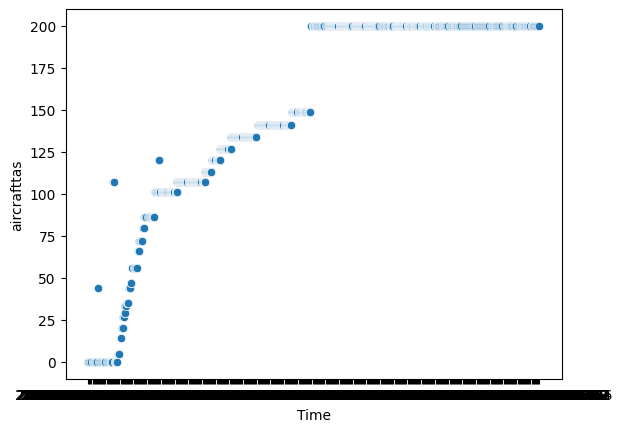

In [230]:
sns.scatterplot(x=df_valid['Time'], y=df_valid['aircrafttas'])

In [50]:
len(df_valid)/10

433.8

In [62]:
df_valid

,particle_idx_seq,Time,phase,xsize,ysize,area,diam,GGALT,WSC,WDC,PALT_A,image_path
0,0,2025-05-24 02:28:03,0,40.0,120.0,20,124.01754,289.19030,0.0,NaN,239.57280,/content/drive/MyDrive/GEOG5100/aircraft_ml/pa...
1,1,2025-05-24 02:32:55,0,20.0,70.0,9,70.82763,289.20755,0.0,NaN,239.42041,/content/drive/MyDrive/GEOG5100/aircraft_ml/pa...
2,2,2025-05-24 02:38:27,0,20.0,70.0,10,70.82763,289.18740,0.0,NaN,236.06760,/content/drive/MyDrive/GEOG5100/aircraft_ml/pa...
3,4643,2025-05-24 02:40:57,0,160.0,130.0,123,162.14363,287.91060,0.0,NaN,236.16284,/content/drive/MyDrive/GEOG5100/aircraft_ml/pa...
4,4644,2025-05-24 02:40:58,0,110.0,160.0,45,190.27756,287.83520,0.0,NaN,236.06760,/content/drive/MyDrive/GEOG5100/aircraft_ml/pa...
...,...,...,...,...,...,...,...,...,...,...,...,...
4333,7171,2025-05-24 08:16:50,1,420.0,7830.0,26679,7830.31350,NaN,NaN,NaN,NaN,/content/drive/MyDrive/GEOG5100/aircraft_ml/pa...
4334,7172,2025-05-24 08:16:52,1,490.0,8440.0,24634,8441.51900,NaN,NaN,NaN,NaN,/content/drive/MyDrive/GEOG5100/aircraft_ml/pa...
4335,4632,2025-05-24 08:16:53,1,580.0,7970.0,-28091,7970.50900,NaN,NaN,NaN,NaN,/content/drive/MyDrive/GEOG5100/aircraft_ml/pa...
4336,7173,2025-05-24 08:16:54,1,560.0,7550.0,23718,7552.39360,NaN,NaN,NaN,NaN,/content/drive/MyDrive/GEOG5100/aircraft_ml/pa...


In [59]:
xticks = []
for x in range(0,len(df_valid),433):
  xticks.append(df_valid['Time'].iloc[x])

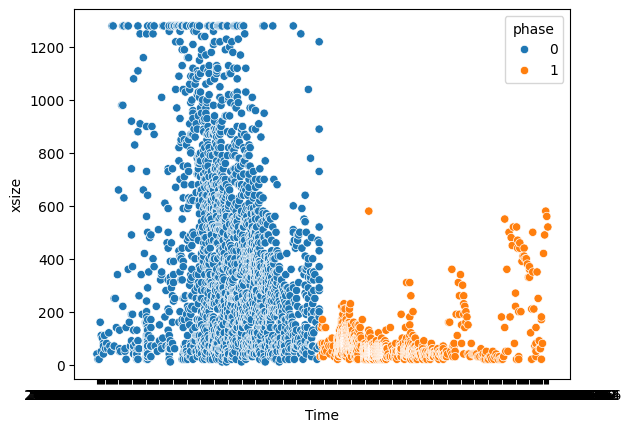

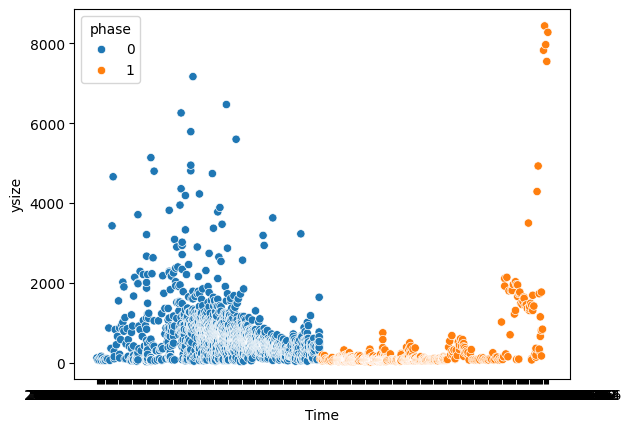

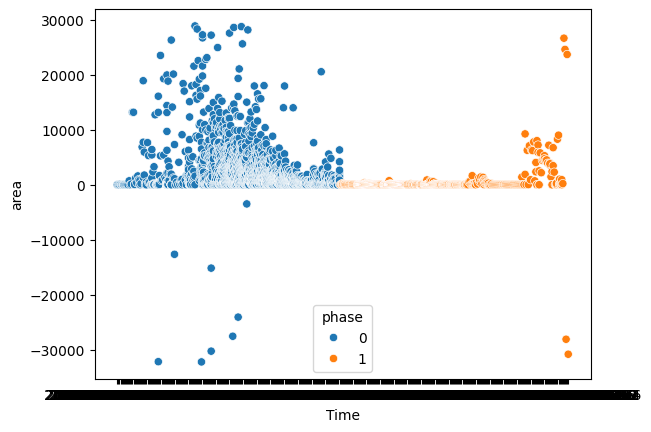

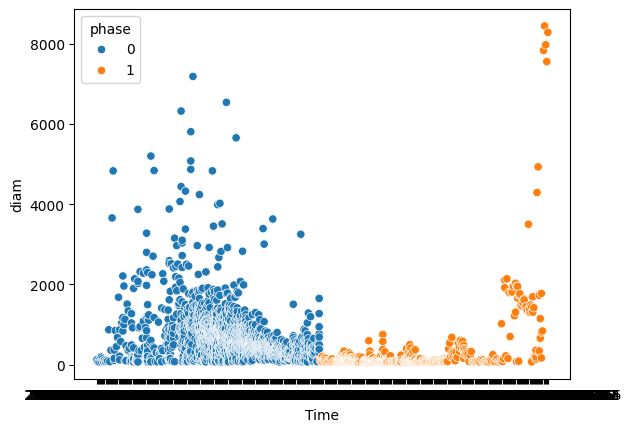

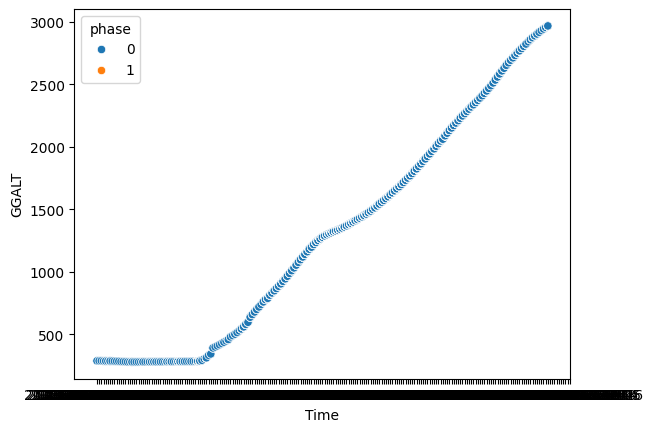

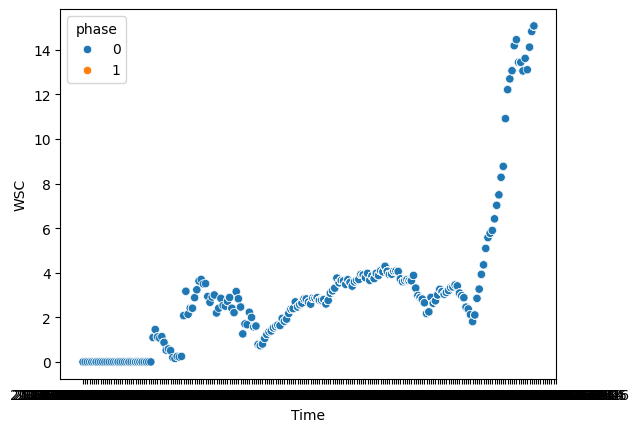

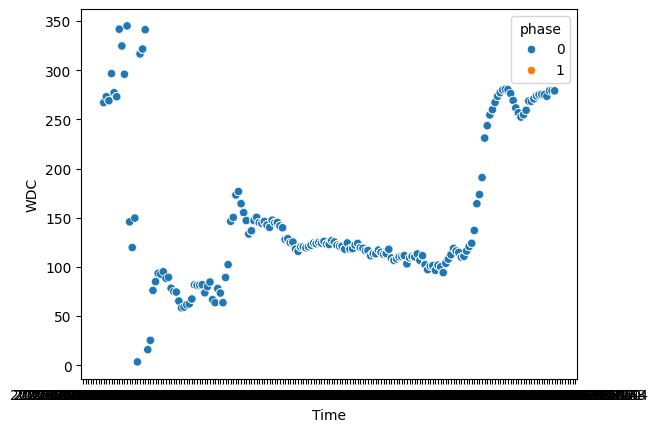

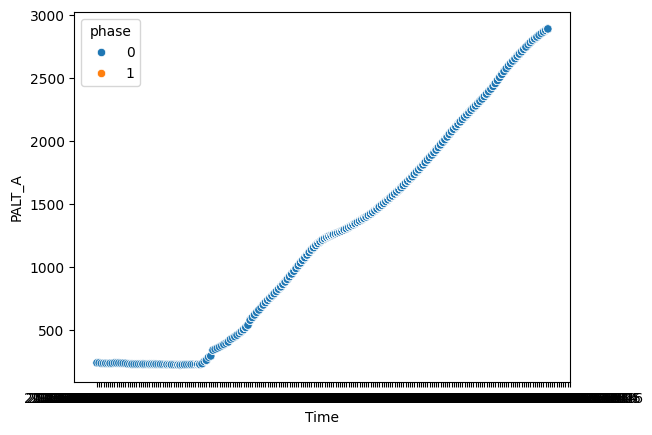

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns
for feature in feature_columns:
  sns.scatterplot(x=df_valid['Time'], y=df_valid[feature], hue=df_valid['phase'])
  plt.show()

<Axes: xlabel='Time', ylabel='diam'>

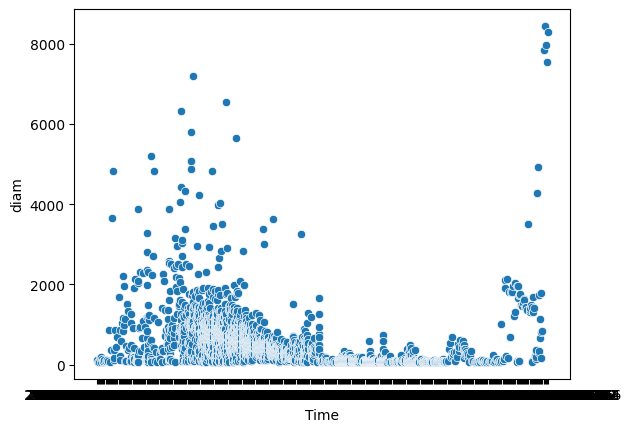

In [231]:
sns.scatterplot(x=df_valid['Time'], y=df_valid['diam'])

## 16. Save Predictions (Optional)

In [185]:
# Save predictions to CSV for further analysis
# predictions_df = pd.DataFrame({
#     'particle_idx_seq': df_valid.iloc[test_indices]['particle_idx_seq'].values,
#     'true_label': y_true,
#     'predicted_label': y_pred,
#     'liquid_probability': y_pred_probs[:, 0],
#     'solid_probability': y_pred_probs[:, 1],
#     'donut_probability': y_pred_probs[:, 2],
#     'noise_probability': y_pred_probs[:, 3],
#     'temperature': X_feat_test[:, 0] * scaler.scale_[0] + scaler.mean_[0],
#     'air_speed': X_feat_test[:, 1] * scaler.scale_[1] + scaler.mean_[1],
#     'altitude': X_feat_test[:, 2] * scaler.scale_[2] + scaler.mean_[2]
# })
# predictions_df.to_csv('particle_predictions_hybrid_4class.csv', index=False)
# print("Predictions saved to 'particle_predictions_hybrid_4class.csv'")

## Notes and Next Steps

### Hybrid 4-Class Model Architecture:
- **CNN branch**: 4 convolutional blocks extract spatial/morphological features from particle images
- **Environmental branch**: Dense layers process temperature, air speed, and altitude
- **Fusion**: Both branches are concatenated before final classification
- **Output**: 4 classes (Liquid, Solid, Donut, Noise)
- **Regularization**: Dropout and BatchNormalization prevent overfitting
- **Class weights**: Applied to handle class imbalance

### Phase Descriptions:
- **Liquid (0)**: Liquid water droplets
- **Solid (1)**: Ice crystals
- **Donut (2)**: Donut-shaped artifacts or special particle types
- **Noise (3)**: Noisy or invalid particle images

### Advantages of Hybrid Approach:
1. **Multi-modal learning**: Combines visual and environmental information
2. **Physical constraints**: Temperature can help disambiguate liquid vs ice
3. **Context awareness**: Altitude and air speed provide atmospheric context
4. **Improved accuracy**: Environmental features can improve classification, especially for ambiguous cases

### Comparison with Image-Only Model:
Compare this hybrid model with the image-only baseline:
1. **Accuracy improvement**: How much do environmental features help overall?
2. **Per-class performance**: Which phases benefit most from environmental data?
3. **Confidence**: Does the hybrid model have higher prediction confidence?
4. **Misclassification patterns**: Does it reduce specific confusion pairs?
5. **Physical consistency**: Are predictions more physically plausible?

### Potential Improvements:
1. **Data augmentation**: Add rotation, flipping, scaling to particle images
2. **Attention mechanisms**: Let the model learn which features matter most
3. **Different architectures**: Try ResNet, EfficientNet, or Vision Transformers
4. **Hyperparameter tuning**: Learning rate, batch size, dropout rates, architecture depth
5. **Ensemble methods**: Combine multiple models
6. **Feature engineering**: Add derived features (e.g., supersaturation, distance from freezing)
7. **Focal loss**: Better handling of hard examples
8. **Cross-validation**: K-fold CV for more robust evaluation

### Key Research Questions:
- How much does temperature improve liquid/solid classification?
- Are donut particles associated with specific atmospheric conditions?
- Can environmental features help filter noise automatically?
- What's the optimal balance between image and environmental features?
- How well does the model generalize across different flight conditions?